## Load All Required Libraries

In [26]:
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import itertools
from imblearn import over_sampling

#To Try different various hyptermeters
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.model_selection import GridSearchCV

#Algo to use for modelling
from sklearn.linear_model import LogisticRegression
import lightgbm as lgbm
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier,  GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import RFE
#from sklearn.tree import DecisionTreeClassifier


#To Mearure Performance of Model
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import  sklearn.metrics as metrics

run_cv=False 
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)

## Common Functions Used in this Project

In [27]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Plotting cv results
def draw_cv_results(cv_df, param_name, metric_name, title_name, log_true):
    plt.figure(figsize=(10,4))
    
    if log_true:
        x_axis= np.log10( list(cv_df[param_name]))
        x_axis_title = "Log Value "+param_name
    else:
        x_axis = list(cv_df[param_name])
        x_axis_title = param_name
        
    plt.plot( x_axis, cv_df['mean_train_score'] )
    plt.plot( x_axis, cv_df['mean_test_score'] )
    plt.xlabel(x_axis_title)
    plt.ylabel(metric_name)
    plt.title(title_name)
    plt.legend(['Train ' + metric_name +' score', 'Test ' +metric_name+' score'], loc='upper left')

    
# Function to plot the confusion Matrix
def draw_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.tab10):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
   
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = 'd' 
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.fill(j,i,facecolor="red" if cm[i, j] < thresh else "blue", edgecolor='b', linewidth=2)
        #plt.Rectangle((0, 0), 1, 0, linewidth=1, edgecolor='b', facecolor='none')
        
        plt.text(j, i, format(cm[i, j], fmt), fontsize=20, weight="bold", 
                 verticalalignment='center',
                 horizontalalignment="center",
                 color="white", 
                 
                bbox=dict(facecolor='red', alpha=0.8))

    plt.tight_layout()
    plt.ylabel('True label',fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    

class_names=[0,1]

def draw_roc( actual, probs, prob_values=True, Threshold_limit=0.4, pred_colname='Unknown' ):
  
    print (pred_colname)
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                          drop_intermediate = False )
    
    threshold = thresholds[np.argmax(tpr-fpr)]

    if prob_values:
        pred= probs.map(lambda x: 1 if x > threshold else 0)
    else:
        pred= probs
    
    prediction[ pred_colname ] = probs
    
    auc_score = round( metrics.roc_auc_score( actual, probs) ,2)
    
    recall    = round( metrics.recall_score(actual,pred),2)
    precision = round(metrics.precision_score(actual, pred),2)
    accuracy  = round(metrics.accuracy_score(actual,pred),2)
    f1= round(metrics.f1_score(actual,pred),2)
    

    plt.figure(figsize=(20, 5))
    plt.subplot(1,2,1)
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]',fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver operating characteristic example',fontsize=20)
    plt.legend(loc="lower right")
    
    plt.subplot(1,2,2)
    cm = confusion_matrix(actual, pred)
    draw_confusion_matrix(cm,class_names)
    plt.show()
    
    print ("This Model Result is for ", model_with_data_list[option], " Data")
    print ("ROC AUC Score on Test:",auc_score," Threshold:{:.5f}".format(threshold))
    print ("Accuracy",accuracy,"AUC:",auc_score,"Recall:",recall,"Precision:",precision,"F1:",f1)
    return accuracy,auc_score,recall,precision,f1

## All the Modles Used in the Program. Parameters are set after performing CV

In [246]:
def process_model_LR(pred_colname):   
    lr = LogisticRegression(C=.01,max_iter=1000, random_state=100)
    print(X_train.shape, y_train.shape)
    lr.fit(X_train,y_train)

    y_val_pred_logistic = lr.predict_proba(X_val)
    y_val_pred_logistic = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_logistic[:,1:2].reshape(-1) })

    #check ROC_AUC Score on Test
    logistic_acc, logistic_auc_val, logistic_recall_val, logistic_precision_val, logistic_f1_val = \
                            draw_roc(y_val_pred_logistic.Class, y_val_pred_logistic.Class_Prob, True, 0.6, pred_colname)
    
    
def process_model_LGBM(pred_colname):
#Hyperparamter Tuning
    #lgbmc = lgbm.LGBMClassifier(n_estimators=100, random_state = 42)
    lgbmc = lgbm.LGBMClassifier(colsample_bytree=1.0,
                   importance_type='split', learning_rate=0.1, max_depth=-1,
                   min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                   n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                   random_state=100, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                   subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

    lgbmc.fit(X_train, y_train) 

    y_val_pred_lgbmc = lgbmc.predict_proba(X_val)[:,1:2].reshape(-1)
    y_val_pred_lgbmc = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_lgbmc  }) #.reshape(-1)

    lgbmc_accuracy_val, lgbmc_auc_val, lgbmc_recall_val, lgbmc_precision_val, lgbmc_f1_val = \
                            draw_roc(y_val_pred_lgbmc.Class, y_val_pred_lgbmc.Class_Prob,True,.6,pred_colname)
    
def process_model_NB(pred_colname):
    #Hyperparamter Tuning
    #lgbmc = lgbm.LGBMClassifier(n_estimators=100, random_state = 42)
    nb = GaussianNB()

    nb.fit(X_train, y_train) 

    y_val_pred_nb = nb.predict_proba(X_val)[:,1:2].reshape(-1)
    y_val_pred_nb = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_nb  }) #.reshape(-1)

    nb_accuracy_val, nb_auc_val, nb_recall_val, nb_precision_val, nb_f1_val = \
                            draw_roc(y_val_pred_nb.Class, y_val_pred_nb.Class_Prob,True,.6,pred_colname)
    
def process_model_GBC(pred_colname):
    gbc = GradientBoostingClassifier() 


    #Hyperparamter Tuning
    #gbc = GradientBoostingClassifier( random_state=100)
    gbc = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                               learning_rate=0.1, loss='deviance', max_depth=3,
                               max_features=None, max_leaf_nodes=None,
                               min_impurity_decrease=0.0, min_impurity_split=None,
                               min_samples_leaf=1, min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=100,
                               n_iter_no_change=None, presort='deprecated',
                               random_state=100, subsample=1.0, tol=0.0001,
                               validation_fraction=0.1, verbose=0,
                               warm_start=False)

    gbc.fit(X_train, y_train) 

    y_val_pred_gbc = gbc.predict_proba(X_val)[:,1:2].reshape(-1)
    y_val_pred_gbc = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_gbc  }) #.reshape(-1)

    gbc_accuracy_val, gbc_auc_val, gbc_recall_val, gbc_precision_val, gbc_f1_val = \
                            draw_roc(y_val_pred_gbc.Class, y_val_pred_gbc.Class_Prob,True, .6, pred_colname)
    
    
def process_model_RFC(pred_colname):
    rfc = RandomForestClassifier() 

    #Hyperparamter Tuning
    rfc = RandomForestClassifier( random_state=100)
    rfc.fit(X_train, y_train) 

    y_val_pred_rfc = rfc.predict_proba(X_val)[:,1:2].reshape(-1)
    y_val_pred_rfc = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_rfc  }) #.reshape(-1)

    rfc_accuracy_val, rfc_auc_val, rfc_recall_val, rfc_precision_val, rfc_f1_val = \
                            draw_roc(y_val_pred_rfc.Class, y_val_pred_rfc.Class_Prob,True,.6, pred_colname)
    
def process_model_ADB(pred_colname):

    #Hyperparamter Tuning
    adbc = AdaBoostClassifier( random_state=100)
    adbc.fit(X_train, y_train) 

    y_val_pred_adbc = adbc.predict_proba(X_val)[:,1:2].reshape(-1)
    y_val_pred_adbc = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_adbc  }) #.reshape(-1)

    adbc_accuracy_val, adbc_auc_val, adbc_recall_val, adbc_precision_val, adbc_f1_val = \
                            draw_roc(y_val_pred_adbc.Class, y_val_pred_adbc.Class_Prob,True,.6,pred_colname)
    
def process_model_SVC(pred_colname):
    svc = SVC()

    #Hyperparamter Tuning
    svc = SVC( random_state=100, probability=True)
    svc.fit(X_train, y_train) 

    y_val_pred_svc = svc.predict_proba(X_val)[:,1:2].reshape(-1)
    y_val_pred_svc = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_svc  }) #.reshape(-1)

    svc_accuracy_val, svc_auc_val, svc_recall_val, svc_precision_val, svc_f1_val = \
                            draw_roc(y_val_pred_svc.Class, y_val_pred_svc.Class_Prob,True, .6, pred_colname)


def process_model_Perceptron(pred_colname):
    from sklearn.linear_model import Perceptron

    perceptron = Perceptron(random_state=100)
    perceptron.fit(X_train, y_train)
    
    y_val_pred_perceptron = perceptron.predict(X_val)
    y_val_pred_perceptron = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_perceptron  }) #.reshape(-1)

    perceptron_accuracy_val, perceptron_auc_val, perceptron_recall_val, perceptron_precision_val, perceptron_f1_val = \
                            draw_roc(y_val_pred_perceptron.Class, y_val_pred_perceptron.Class_Prob,False, .6, pred_colname)
    
    
def process_model_lbgmc_FE(pred_colname):
    lgbmc_FE = lgbm.LGBMClassifier(colsample_bytree=1.0,
                   importance_type='split', learning_rate=0.1, max_depth=-1,
                   min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                   n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                   random_state=100, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                   subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

    lgbmc_FE.fit(X_train, y_train) 

    y_val_pred_lgbmcFE = lgbmc_FE.predict_proba(X_val)[:,1:2].reshape(-1)

    y_val_pred_lgbmcFE = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_lgbmcFE  }) #.reshape(-1)

    lgbmcFE_accuracy_val, lgbmcFE_auc_val, lgbmcFE_recall_val, lgbmcFE_precision_val, lgbmcFE_f1_val = \
                            draw_roc(y_val_pred_lgbmcFE.Class, y_val_pred_lgbmcFE.Class_Prob,True,.6,pred_colname)
    
    


## Variables Used in the program

In [37]:
#paths required
datafolder_p = r'D:\18-DS\github\SDSHL\data\processed'
datafolder_e = r'D:\18-DS\github\SDSHL\data\external'
datafolder_i = r'D:\18-DS\github\SDSHL\data\internal'
modelfolder  = r'D:\18-DS\data\models'

file_train = datafolder_p + r'\2-train.csv'
file_test = datafolder_p + r'\2-test.csv'
file_org  = datafolder_p + r'\1-Hinglish_SarcasmCSV.csv'

embed_name={
1: 'tfidf'             ,
2: 'word2vec'          ,
3: 'bow'               ,
4: 'bert_indicnlp'     ,
5: 'bert_multiling'    ,
6: 'fasttext'          ,
7: 'fasttext_indicnlp' ,
8: 'fasttext_wiki'     ,
}

#These file names without end train & test and .csv (extention)
embed_file={
'tfidf'             : r'\embedding_tfidf.csv',
'word2vec'          : r'\embedding_w2v.csv',
'bow'               : r'\embedding_bow.csv',
'bert_indicnlp'     : r'\embedding_bert768_indicnlp_pretrained.csv',
'bert_multiling'    : r'\embedding_bert768_mbert_pretrained.csv',
'fasttext'          : r'\embedding_ft_local.csv',
'fasttext_indicnlp' : r'\embedding_ft300_indicnlp_pretrained.csv',
'fastext_wiki'      : r'\embedding_ft300_wiki_pretrained.csv'
}

#All Prediction Results  of different models with different embedding are saved in this dict
prediction={}

## Create Train Test Split Dataset for different Embedding

In [30]:
#When we want to use different data balancing tacheck we can use option variable below
model_with_data_list=['Normal','RandomOverSampler','Smote','AdaSyn']
option = 0 #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<  Change this to chose different different data balancing Technqiue

def read_embedding_data(embed_number):
    #embed_number=3 #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Change this
    print (embed_name[embed_number])

    file_data = datafolder_p +  embed_file[ embed_name[embed_number] ]
    df = pd.read_csv(file_data, index_col="ID")

    #This strategy of test train split is taken to ensure that all embedding has same set of records
    df_train =  pd.read_csv(file_train, index_col="ID", sep='\t')
    df_test  =  pd.read_csv(file_test, index_col="ID", sep='\t')
    idx_train = list(df_train.index)
    idx_test  = list(df_test.index)

    X_train = df.loc[ idx_train,]
    X_val  = df.loc[ idx_test,]

    y_train1 = X_train['label']
    y_val1   = X_val['label']
    X_train1 = X_train.drop(columns=['label'])
    X_val1  = X_val.drop(columns=['label'])

    print( X_train1.shape, X_val1.shape, y_train1.shape, y_val1.shape)

    ##########################################################################################3
    #Data Imbalance - Over Sampling    

    if option==0:
        X_train, X_val, y_train, y_val = X_train1, X_val1, y_train1, y_val1

    elif option==1:
        ros = over_sampling.RandomOverSampler(random_state=100)
        X_train_ros, y_train_ros       = ros.fit_resample(X_train1, y_train1)

        X_train, X_val, y_train, y_val = X_train_ros, X_val1, y_train_ros , y_val1

    elif option==2:
        smt = over_sampling.SMOTE(random_state=100)
        X_train_smote, y_train_smote   = smt.fit_resample(X_train1, y_train1)

        X_train, X_val, y_train, y_val = X_train_smote, X_val1, y_train_smote , y_val1

    elif option==3:
        ada = over_sampling.ADASYN(random_state=100)
        X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train1, y_train1)

        X_train, X_val, y_train, y_val = X_train_adasyn, X_val1, y_train_adasyn , y_val1


    print ( 'Oversampling Technique Used:' + model_with_data_list[option])
    print( X_train.shape, X_val.shape, y_train.shape, y_val.shape)
    return X_train,X_val, y_train, y_val

## Fit the model. Predict Results. Call all the 8 models with 8 Embedding

tfidf
(1800, 15) (200, 15) (1800,) (200,)
Oversampling Technique Used:Normal
(1800, 15) (200, 15) (1800,) (200,)
(1800, 15) (1800,)
tfidf_LR


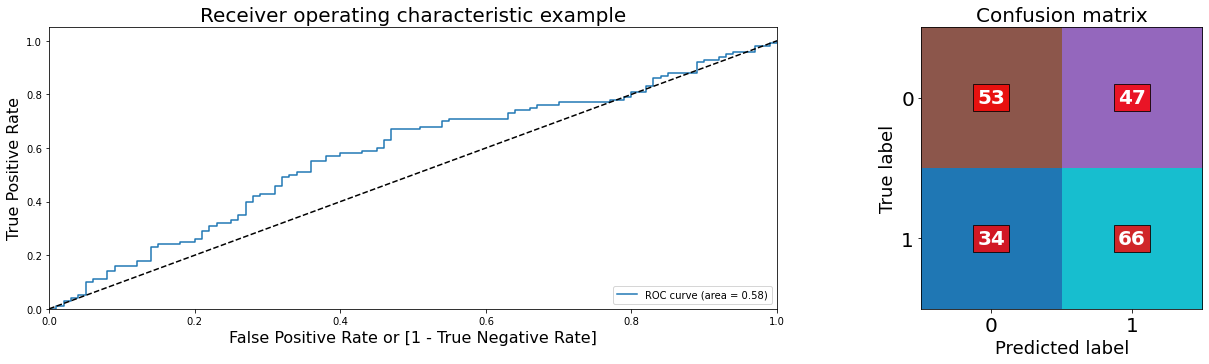

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.58  Threshold:0.49841
Accuracy 0.6 AUC: 0.58 Recall: 0.66 Precision: 0.58 F1: 0.62
tfidf_LGBM


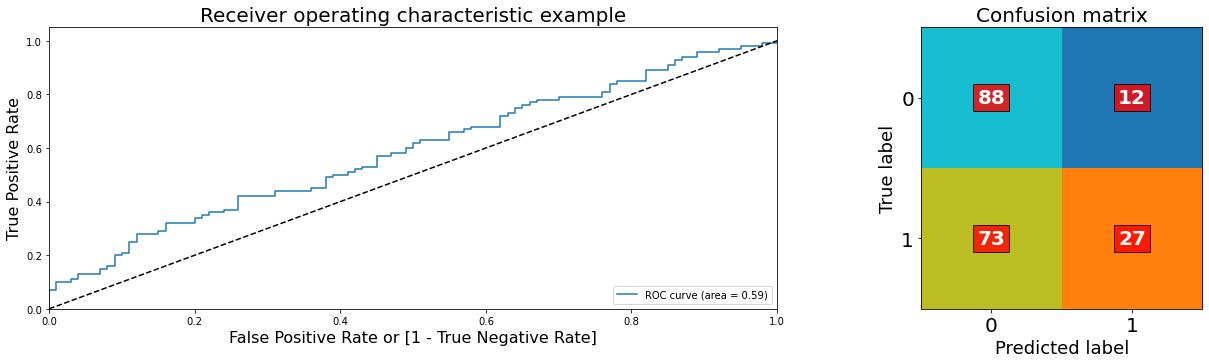

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.59  Threshold:0.70641
Accuracy 0.57 AUC: 0.59 Recall: 0.27 Precision: 0.69 F1: 0.39
tfidf_NB


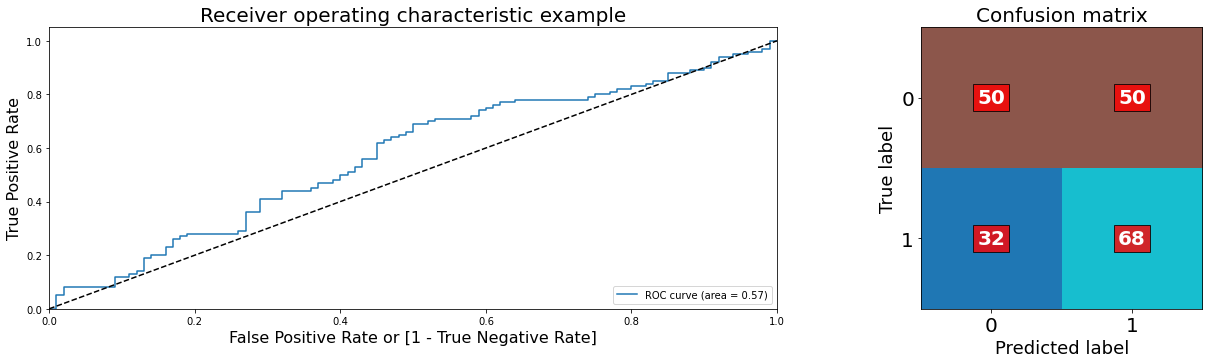

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.57  Threshold:0.42328
Accuracy 0.59 AUC: 0.57 Recall: 0.68 Precision: 0.58 F1: 0.62
tfidf_SVC


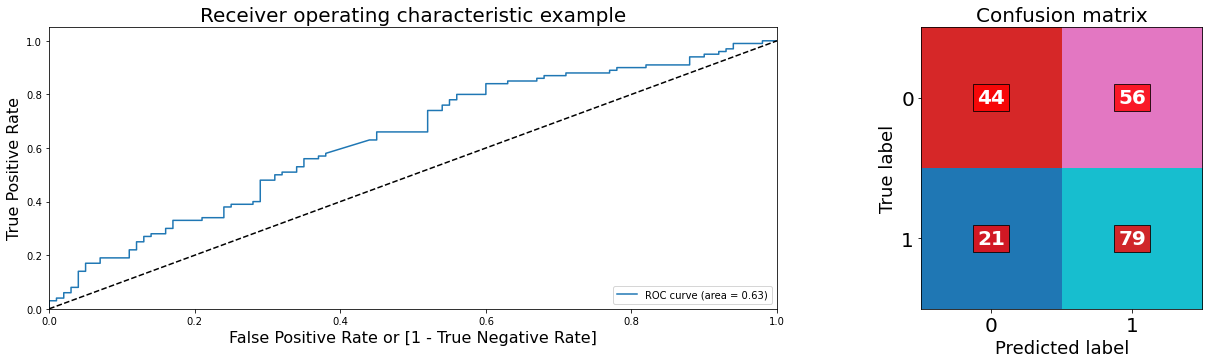

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.63  Threshold:0.46795
Accuracy 0.62 AUC: 0.63 Recall: 0.79 Precision: 0.59 F1: 0.67
tfidf_ADB


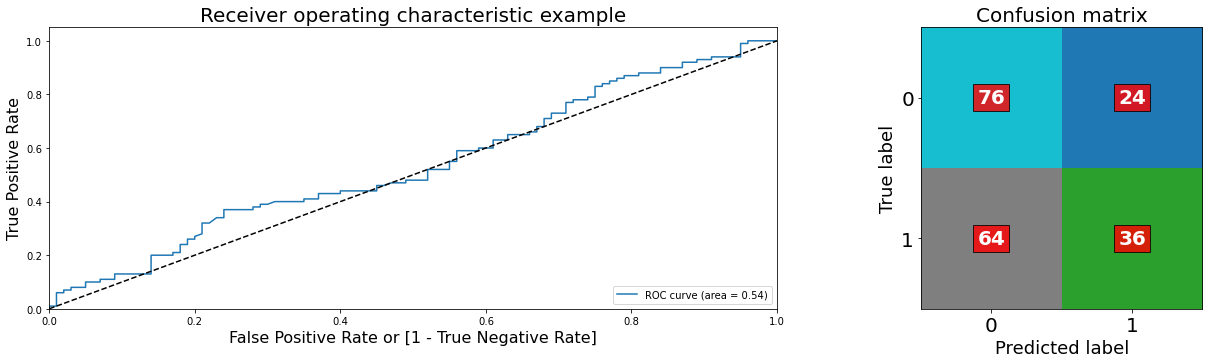

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.54  Threshold:0.50145
Accuracy 0.56 AUC: 0.54 Recall: 0.36 Precision: 0.6 F1: 0.45
tfidf_GBC


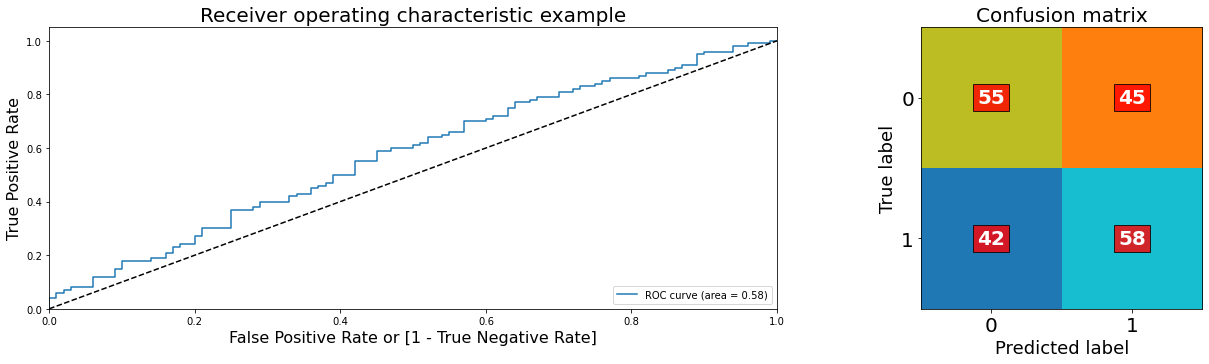

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.58  Threshold:0.48337
Accuracy 0.56 AUC: 0.58 Recall: 0.58 Precision: 0.56 F1: 0.57
tfidf_RFC


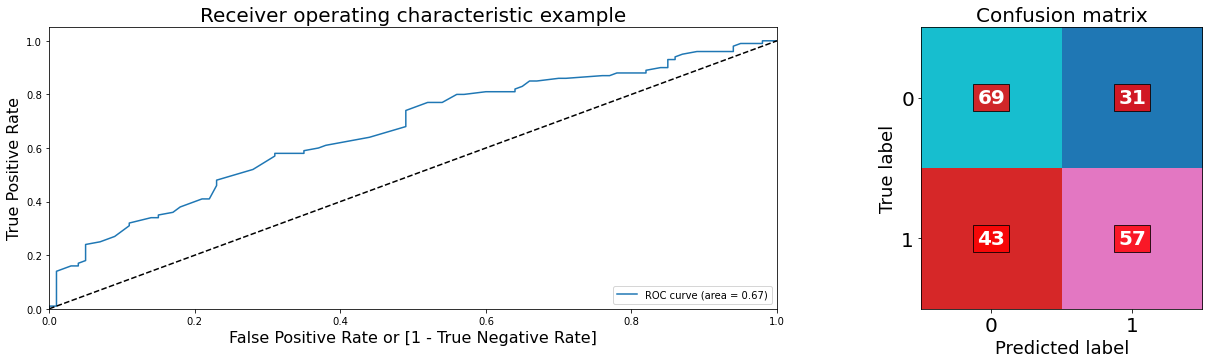

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.67  Threshold:0.52500
Accuracy 0.63 AUC: 0.67 Recall: 0.57 Precision: 0.65 F1: 0.61
tfidf_Perceptron


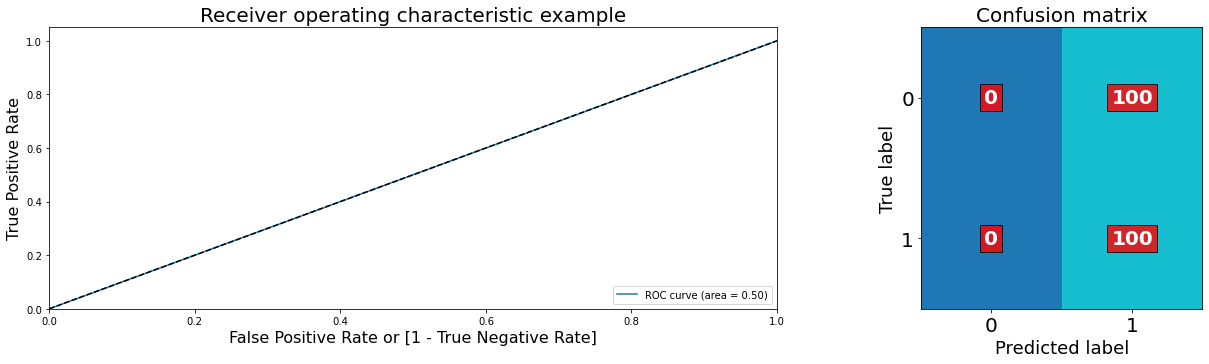

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.5  Threshold:2.00000
Accuracy 0.5 AUC: 0.5 Recall: 1.0 Precision: 0.5 F1: 0.67
word2vec
(1800, 15) (200, 15) (1800,) (200,)
Oversampling Technique Used:Normal
(1800, 15) (200, 15) (1800,) (200,)
(1800, 15) (1800,)
word2vec_LR


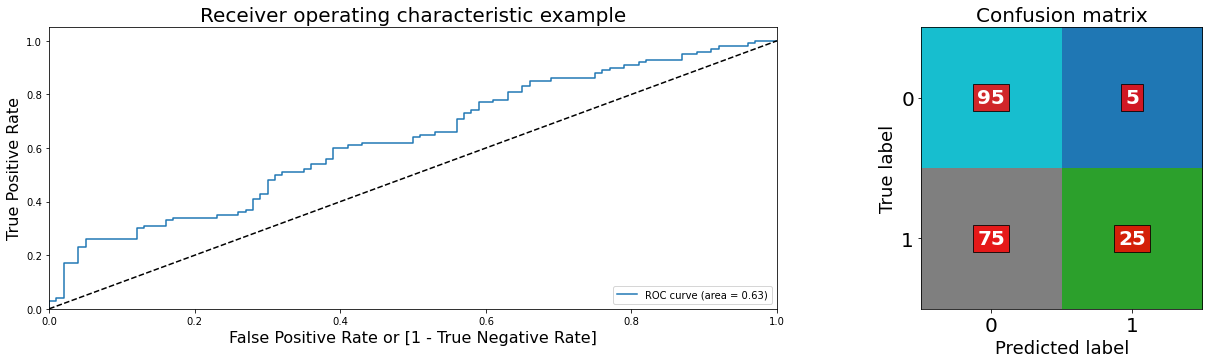

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.63  Threshold:0.56303
Accuracy 0.6 AUC: 0.63 Recall: 0.25 Precision: 0.83 F1: 0.38
word2vec_LGBM


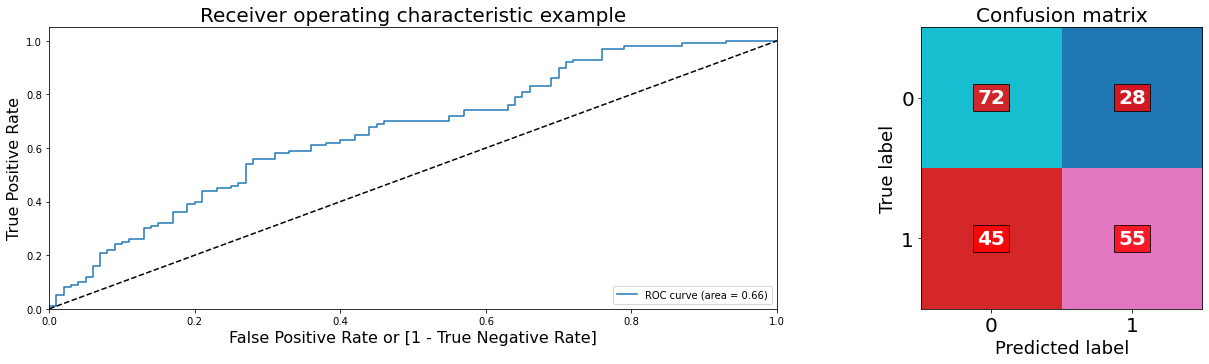

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.66  Threshold:0.59090
Accuracy 0.64 AUC: 0.66 Recall: 0.55 Precision: 0.66 F1: 0.6
word2vec_NB


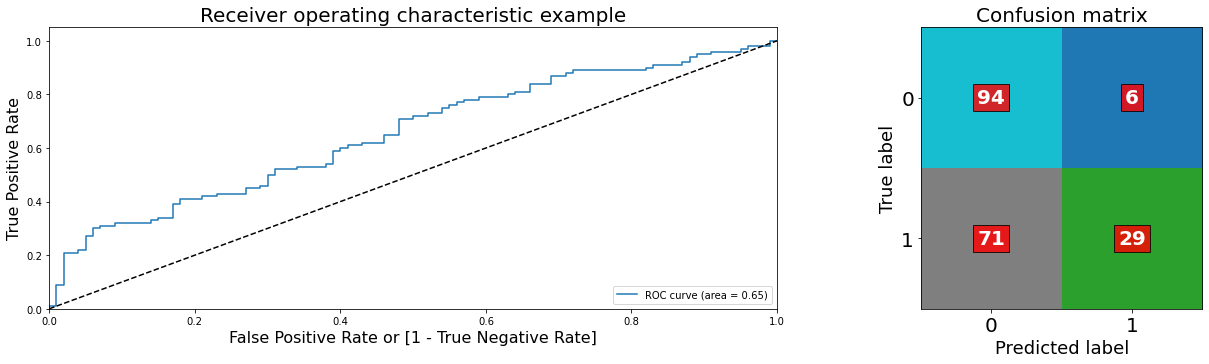

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.65  Threshold:0.87977
Accuracy 0.62 AUC: 0.65 Recall: 0.29 Precision: 0.83 F1: 0.43
word2vec_SVC


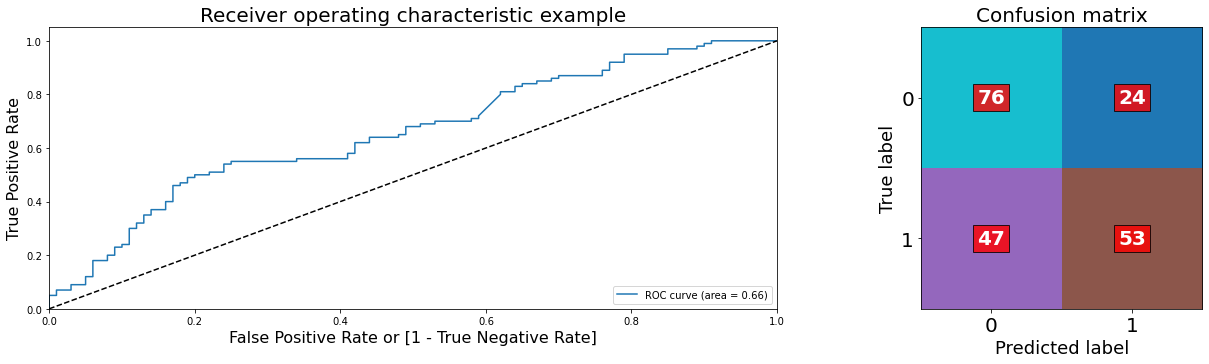

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.66  Threshold:0.60817
Accuracy 0.64 AUC: 0.66 Recall: 0.53 Precision: 0.69 F1: 0.6
word2vec_ADB


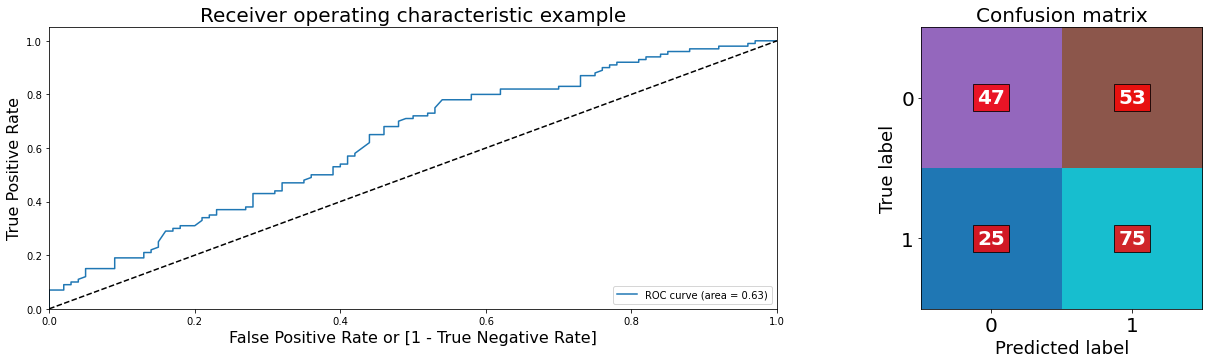

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.63  Threshold:0.50056
Accuracy 0.61 AUC: 0.63 Recall: 0.75 Precision: 0.59 F1: 0.66
word2vec_GBC


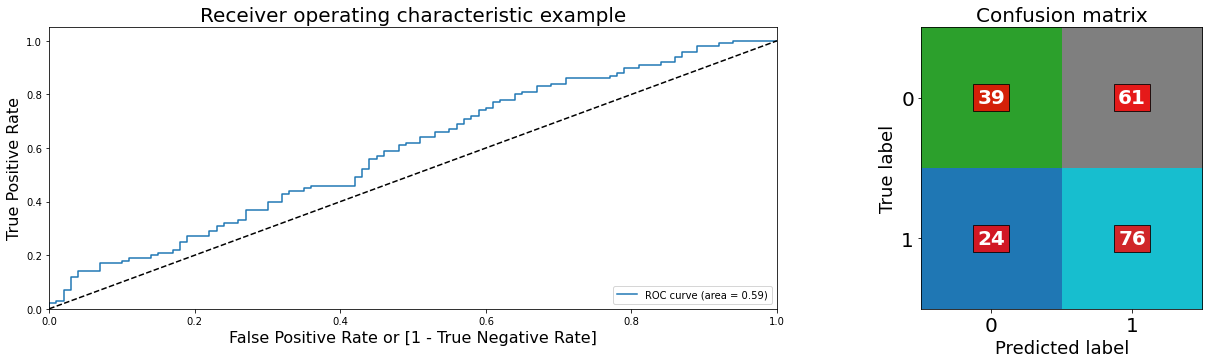

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.59  Threshold:0.50679
Accuracy 0.57 AUC: 0.59 Recall: 0.76 Precision: 0.55 F1: 0.64
word2vec_RFC


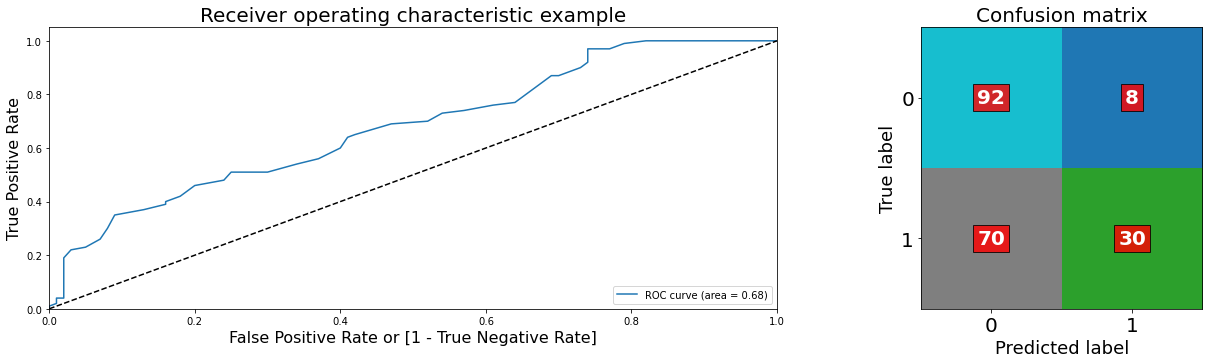

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.68  Threshold:0.67000
Accuracy 0.61 AUC: 0.68 Recall: 0.3 Precision: 0.79 F1: 0.43
word2vec_Perceptron


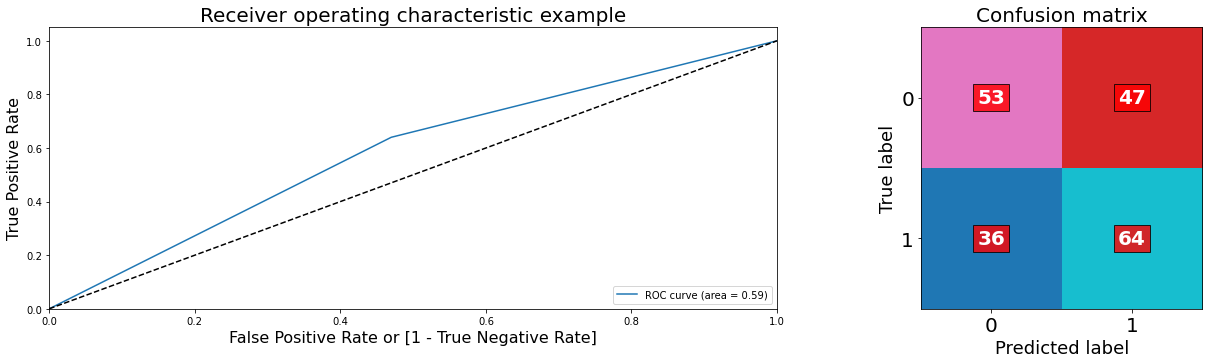

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.59  Threshold:1.00000
Accuracy 0.58 AUC: 0.59 Recall: 0.64 Precision: 0.58 F1: 0.61
bow
(1800, 15) (200, 15) (1800,) (200,)
Oversampling Technique Used:Normal
(1800, 15) (200, 15) (1800,) (200,)
(1800, 15) (1800,)
bow_LR


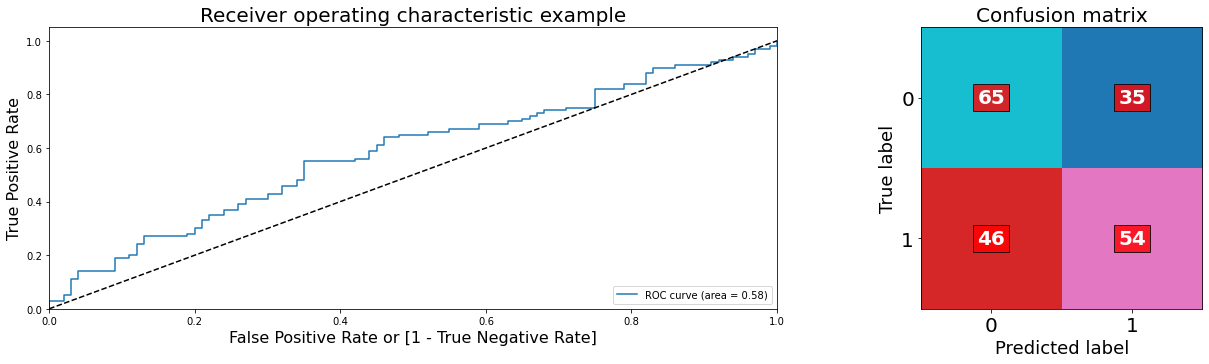

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.58  Threshold:0.49297
Accuracy 0.6 AUC: 0.58 Recall: 0.54 Precision: 0.61 F1: 0.57
bow_LGBM


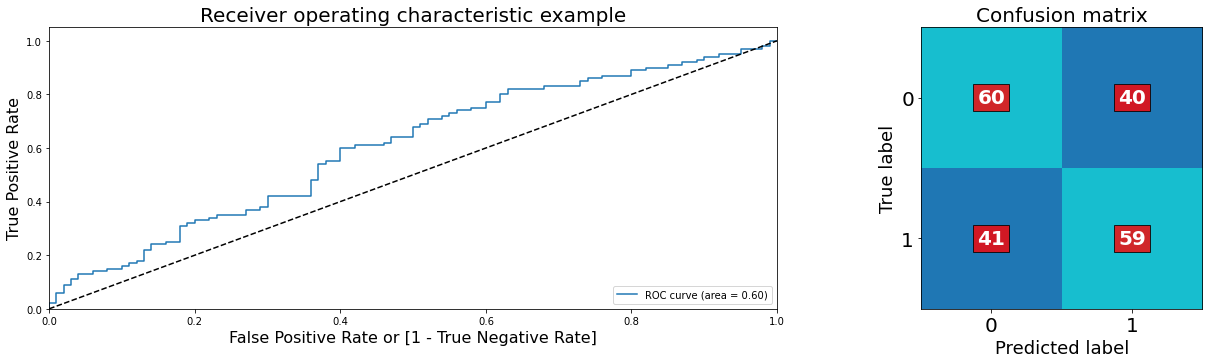

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.6  Threshold:0.45382
Accuracy 0.6 AUC: 0.6 Recall: 0.59 Precision: 0.6 F1: 0.59
bow_NB


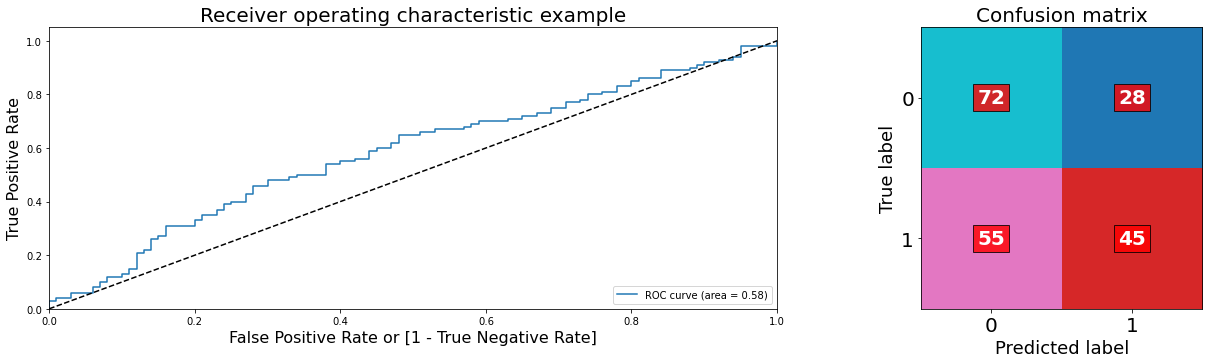

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.58  Threshold:0.49450
Accuracy 0.58 AUC: 0.58 Recall: 0.45 Precision: 0.62 F1: 0.52
bow_SVC


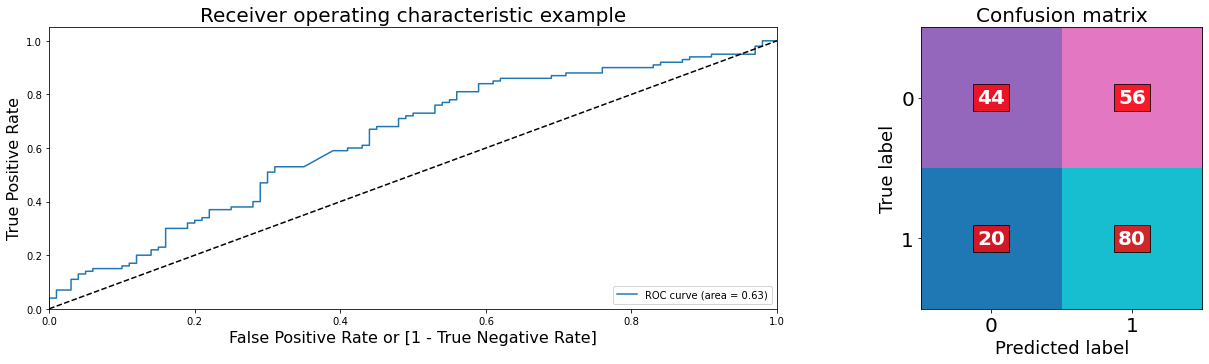

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.63  Threshold:0.44217
Accuracy 0.62 AUC: 0.63 Recall: 0.8 Precision: 0.59 F1: 0.68
bow_ADB


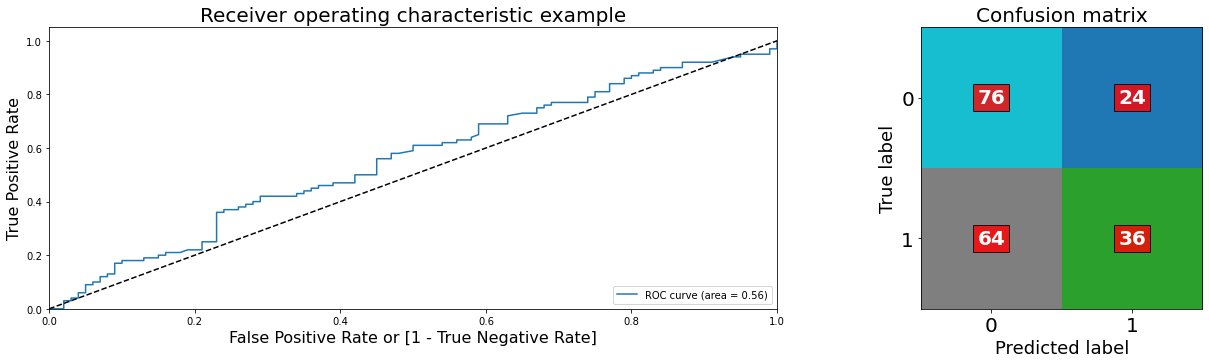

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.56  Threshold:0.50179
Accuracy 0.56 AUC: 0.56 Recall: 0.36 Precision: 0.6 F1: 0.45
bow_GBC


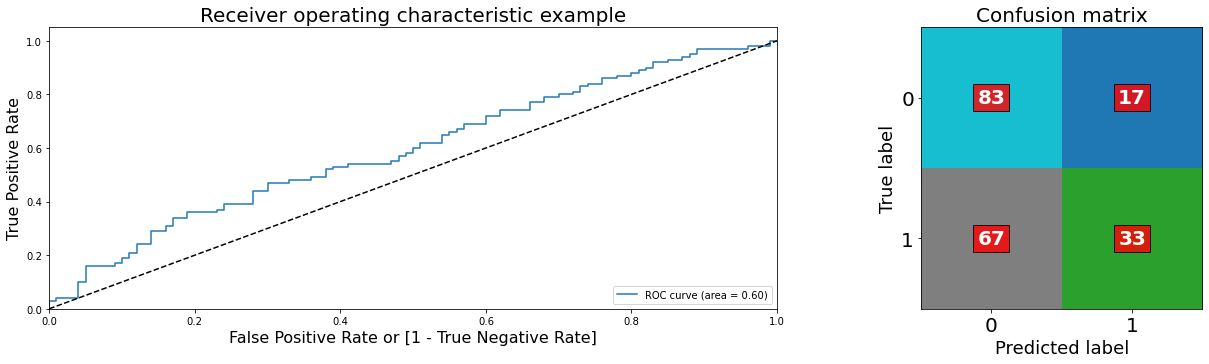

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.6  Threshold:0.58385
Accuracy 0.58 AUC: 0.6 Recall: 0.33 Precision: 0.66 F1: 0.44
bow_RFC


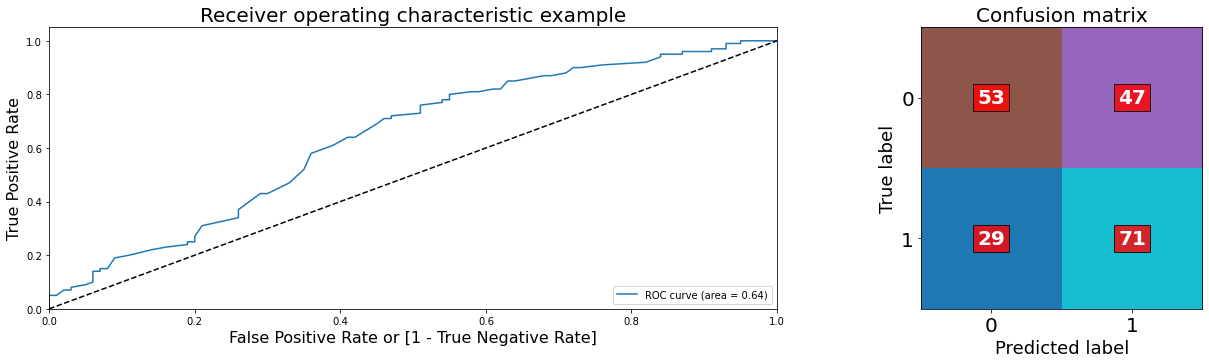

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.64  Threshold:0.46167
Accuracy 0.62 AUC: 0.64 Recall: 0.71 Precision: 0.6 F1: 0.65
bow_Perceptron


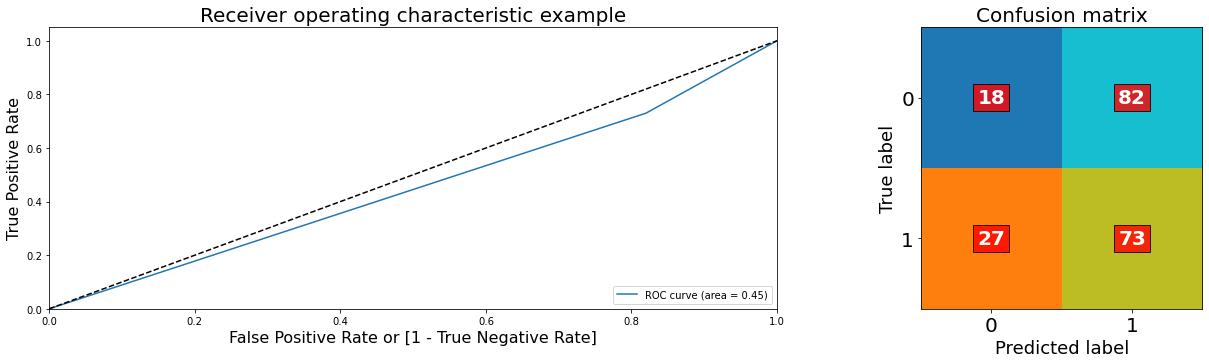

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.45  Threshold:2.00000
Accuracy 0.46 AUC: 0.45 Recall: 0.73 Precision: 0.47 F1: 0.57
bert_indicnlp
(1800, 768) (200, 768) (1800,) (200,)
Oversampling Technique Used:Normal
(1800, 768) (200, 768) (1800,) (200,)
(1800, 768) (1800,)
bert_indicnlp_LR


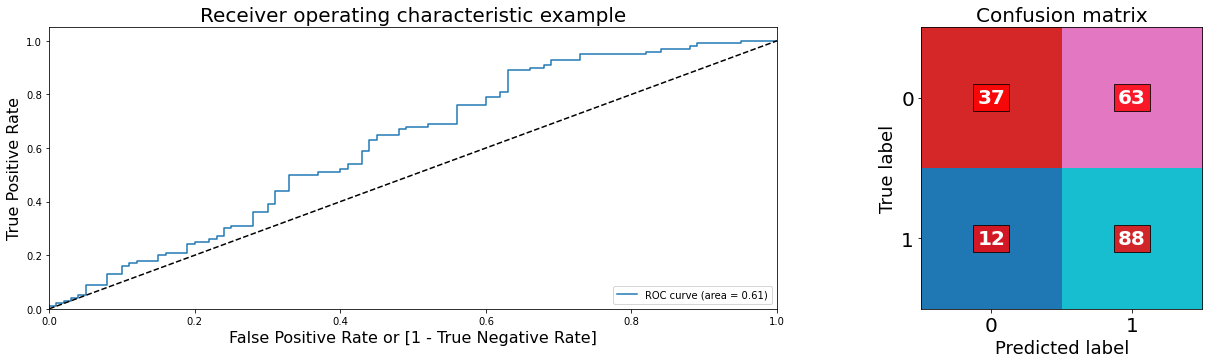

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.61  Threshold:0.49950
Accuracy 0.62 AUC: 0.61 Recall: 0.88 Precision: 0.58 F1: 0.7
bert_indicnlp_LGBM


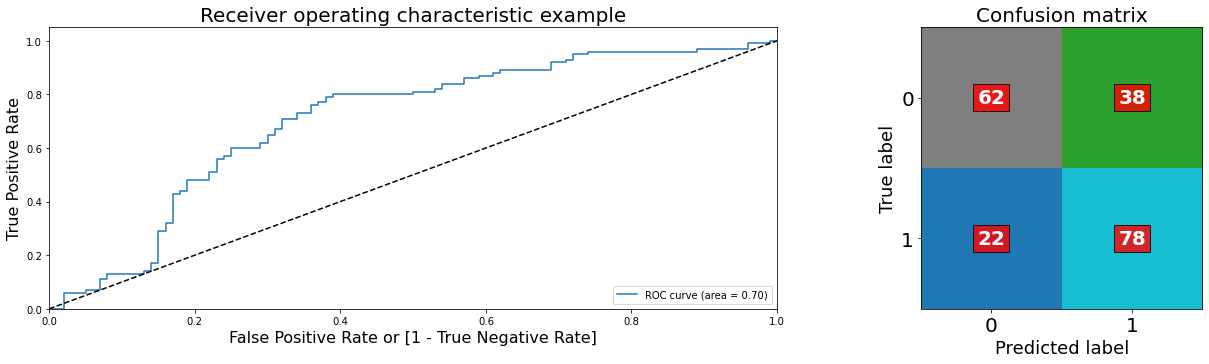

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.7  Threshold:0.42060
Accuracy 0.7 AUC: 0.7 Recall: 0.78 Precision: 0.67 F1: 0.72
bert_indicnlp_NB


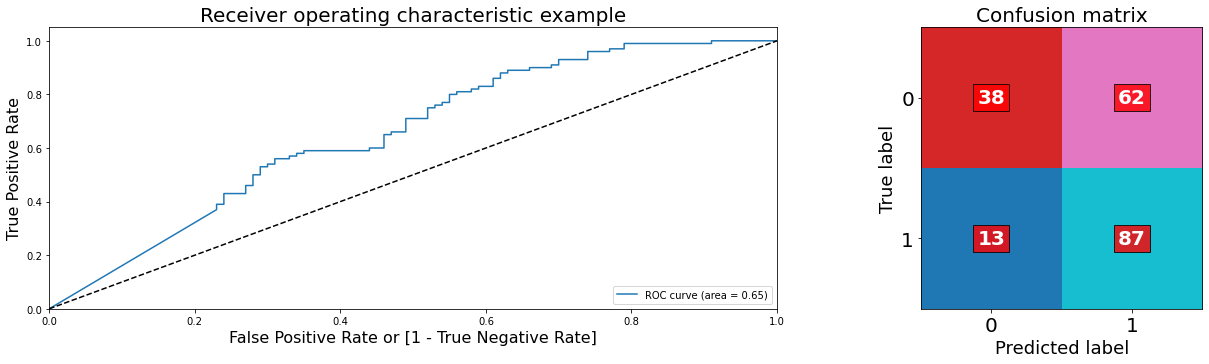

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.65  Threshold:0.00000
Accuracy 0.62 AUC: 0.65 Recall: 0.87 Precision: 0.58 F1: 0.7
bert_indicnlp_SVC


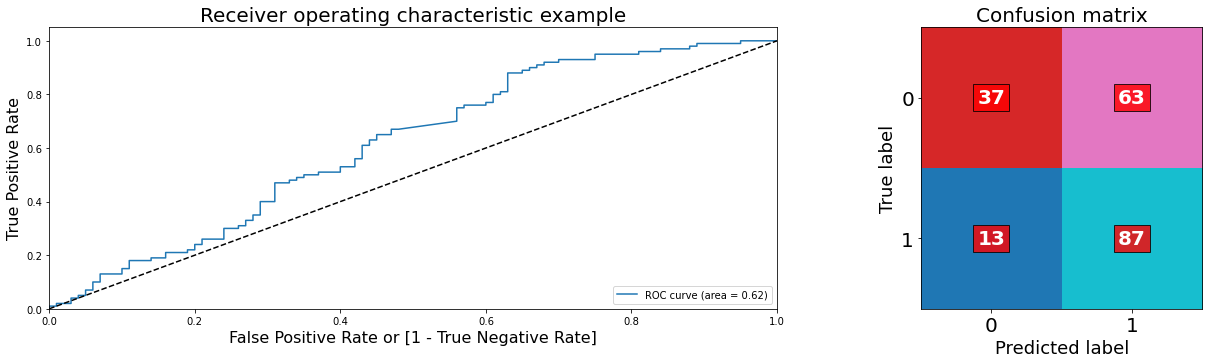

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.62  Threshold:0.48105
Accuracy 0.62 AUC: 0.62 Recall: 0.87 Precision: 0.58 F1: 0.7
bert_indicnlp_ADB


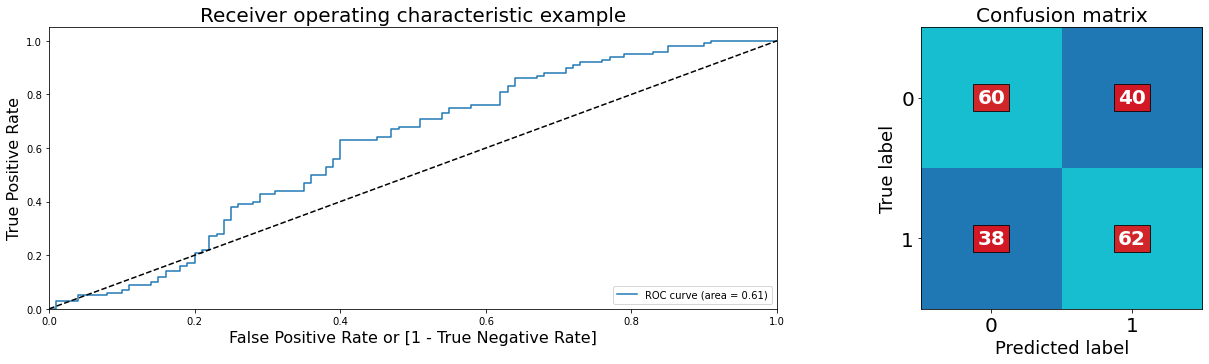

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.61  Threshold:0.49962
Accuracy 0.61 AUC: 0.61 Recall: 0.62 Precision: 0.61 F1: 0.61
bert_indicnlp_GBC


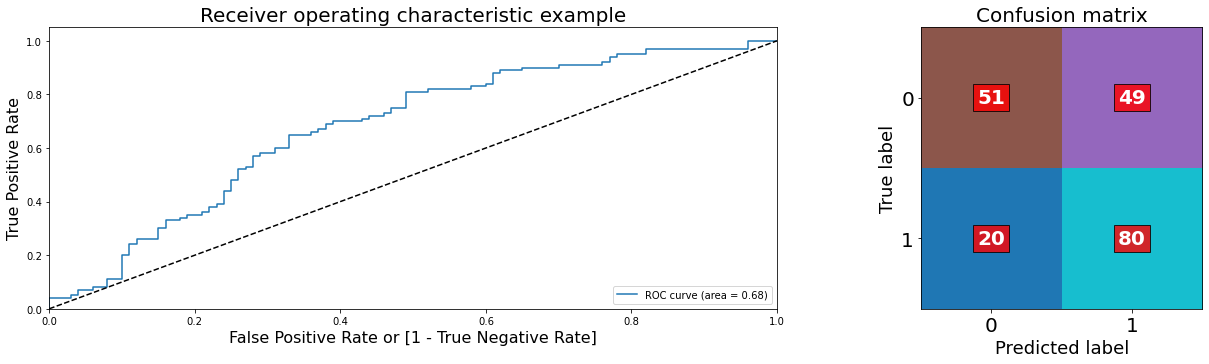

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.68  Threshold:0.38972
Accuracy 0.66 AUC: 0.68 Recall: 0.8 Precision: 0.62 F1: 0.7
bert_indicnlp_RFC


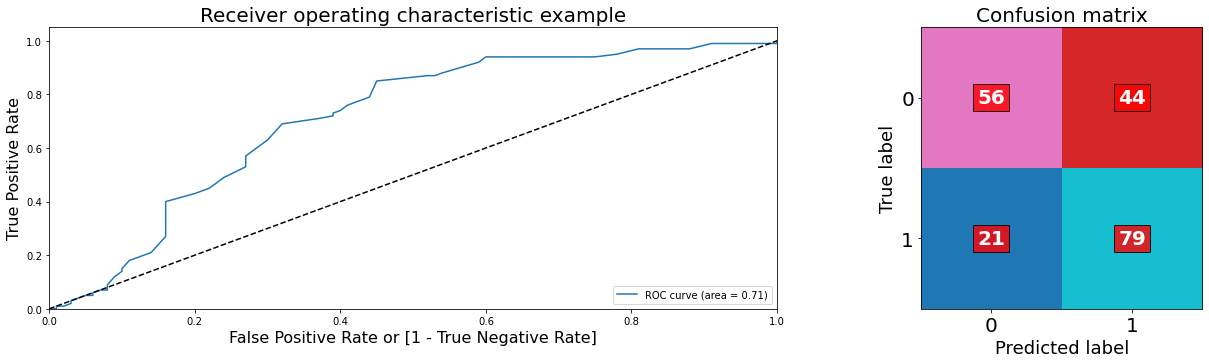

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.71  Threshold:0.45000
Accuracy 0.68 AUC: 0.71 Recall: 0.79 Precision: 0.64 F1: 0.71
bert_indicnlp_Perceptron


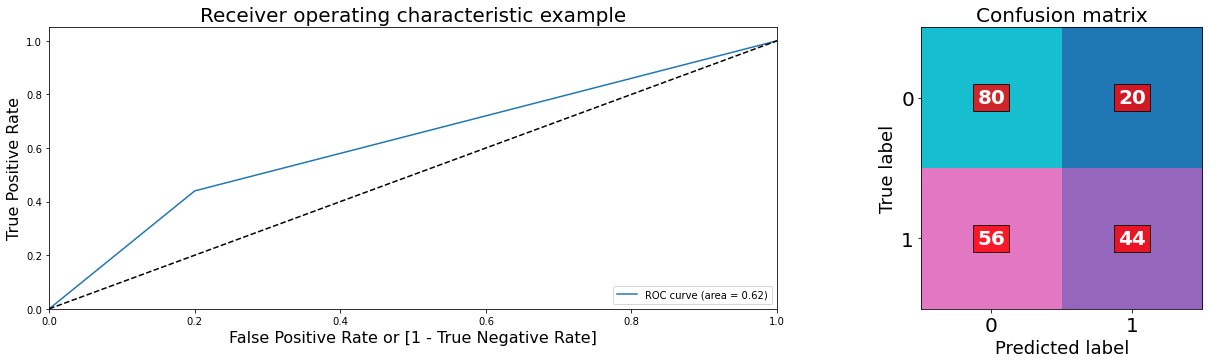

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.62  Threshold:1.00000
Accuracy 0.62 AUC: 0.62 Recall: 0.44 Precision: 0.69 F1: 0.54
bert_multiling
(1800, 768) (200, 768) (1800,) (200,)
Oversampling Technique Used:Normal
(1800, 768) (200, 768) (1800,) (200,)
(1800, 768) (1800,)
bert_multiling_LR


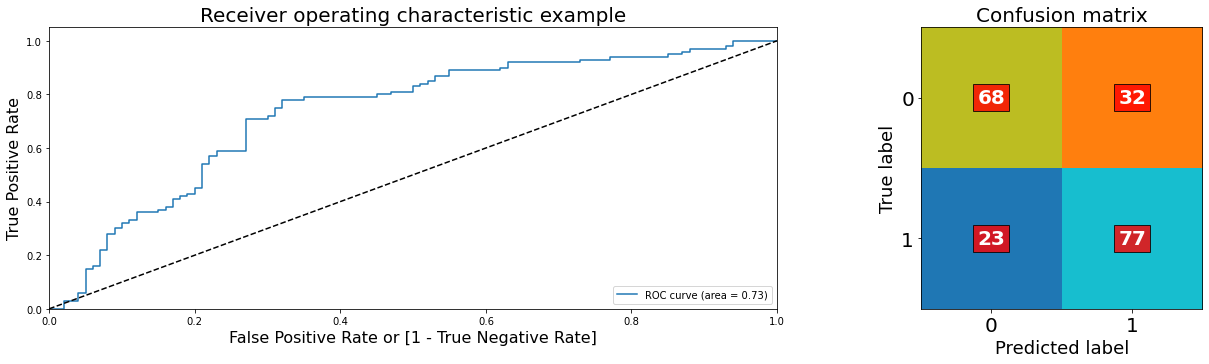

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.73  Threshold:0.49149
Accuracy 0.72 AUC: 0.73 Recall: 0.77 Precision: 0.71 F1: 0.74
bert_multiling_LGBM


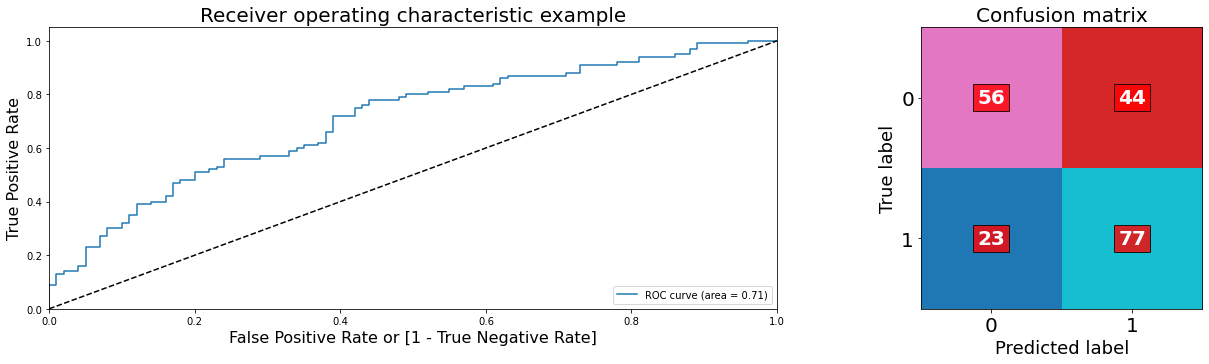

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.71  Threshold:0.36530
Accuracy 0.66 AUC: 0.71 Recall: 0.77 Precision: 0.64 F1: 0.7
bert_multiling_NB


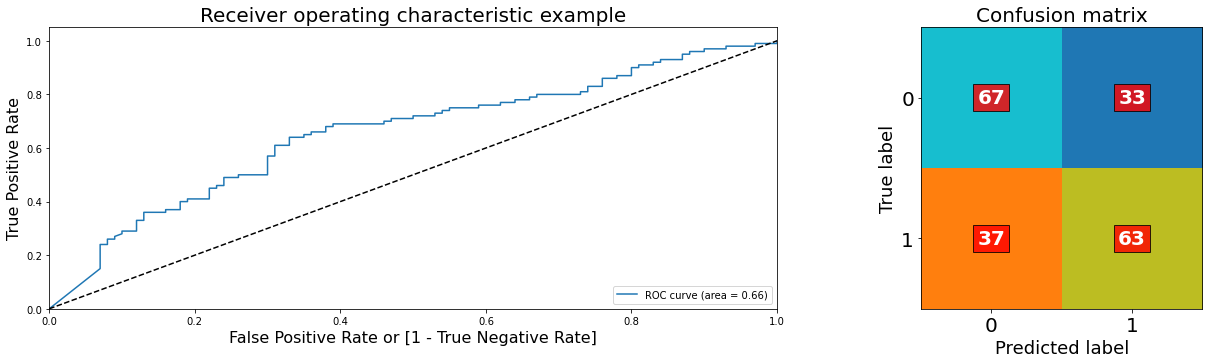

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.66  Threshold:1.00000
Accuracy 0.65 AUC: 0.66 Recall: 0.63 Precision: 0.66 F1: 0.64
bert_multiling_SVC


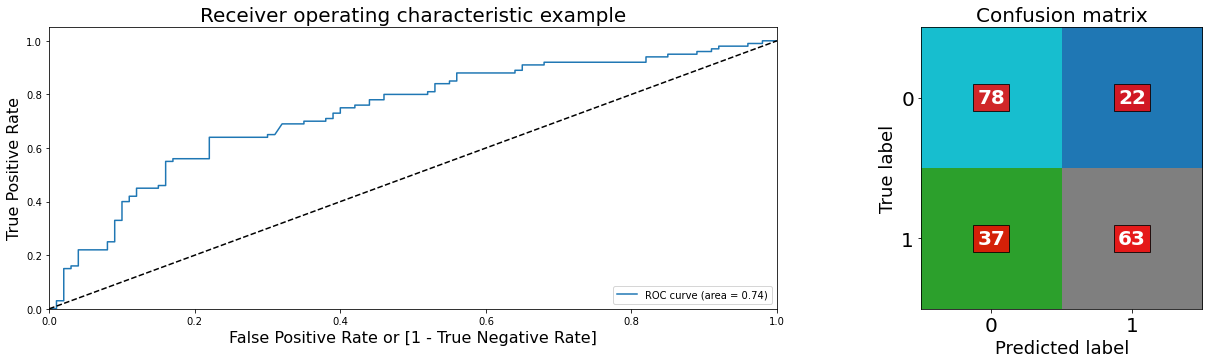

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.74  Threshold:0.53018
Accuracy 0.7 AUC: 0.74 Recall: 0.63 Precision: 0.74 F1: 0.68
bert_multiling_ADB


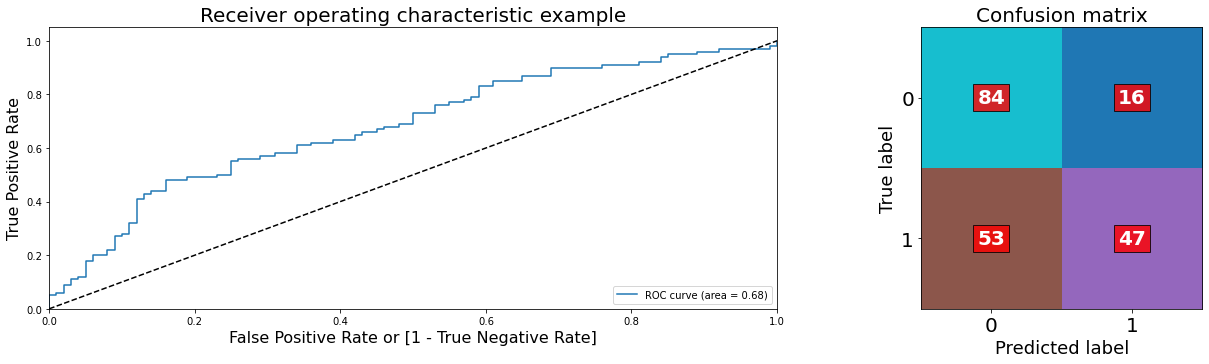

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.68  Threshold:0.50311
Accuracy 0.66 AUC: 0.68 Recall: 0.47 Precision: 0.75 F1: 0.58
bert_multiling_GBC


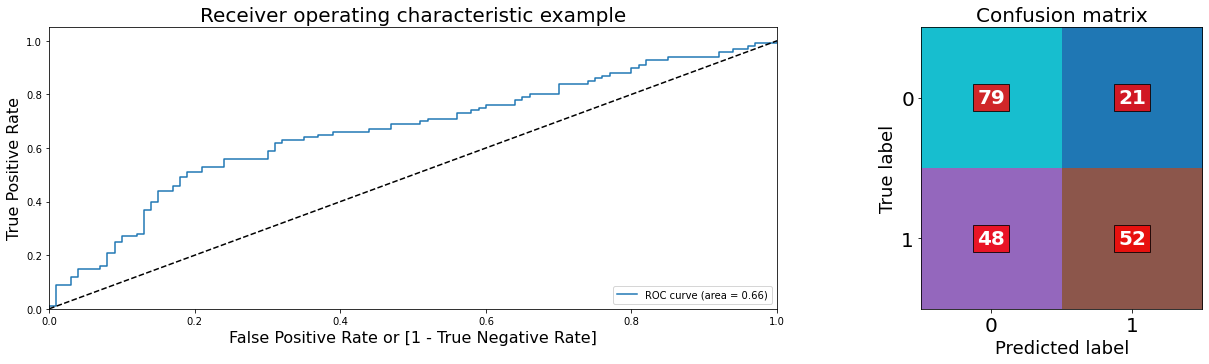

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.66  Threshold:0.56525
Accuracy 0.66 AUC: 0.66 Recall: 0.52 Precision: 0.71 F1: 0.6
bert_multiling_RFC


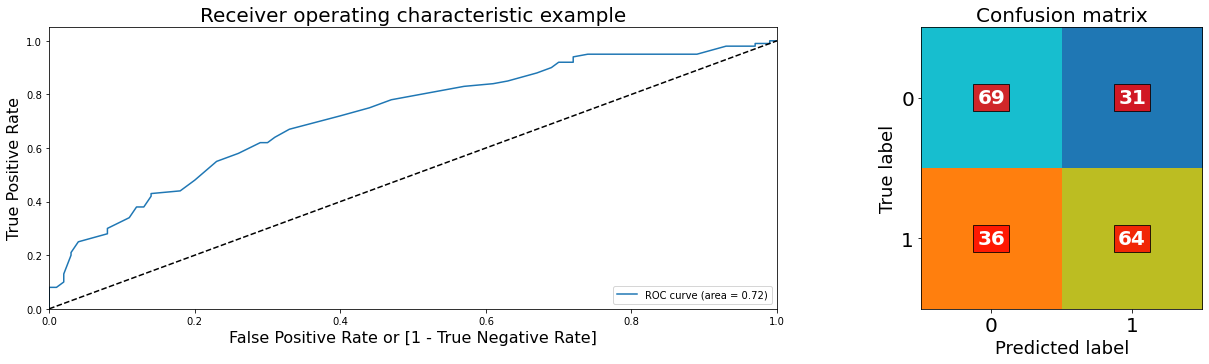

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.72  Threshold:0.50000
Accuracy 0.66 AUC: 0.72 Recall: 0.64 Precision: 0.67 F1: 0.66
bert_multiling_Perceptron


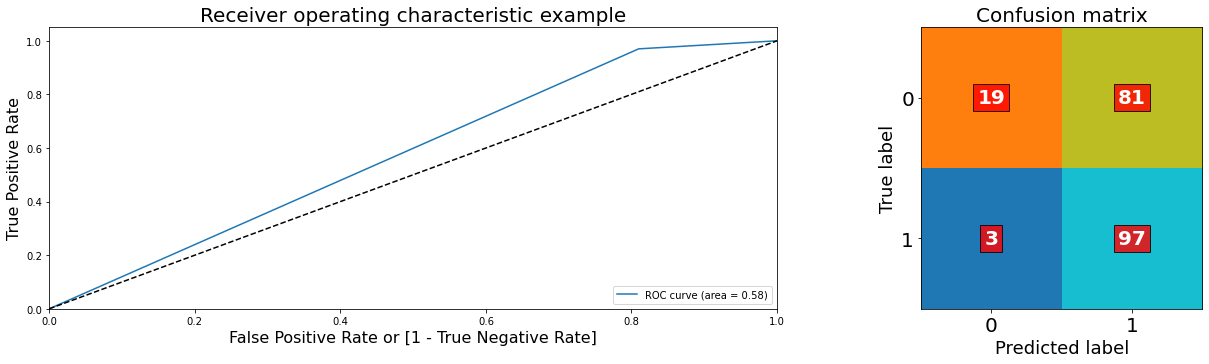

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.58  Threshold:1.00000
Accuracy 0.58 AUC: 0.58 Recall: 0.97 Precision: 0.54 F1: 0.7
fasttext
(1800, 15) (200, 15) (1800,) (200,)
Oversampling Technique Used:Normal
(1800, 15) (200, 15) (1800,) (200,)
(1800, 15) (1800,)
fasttext_LR


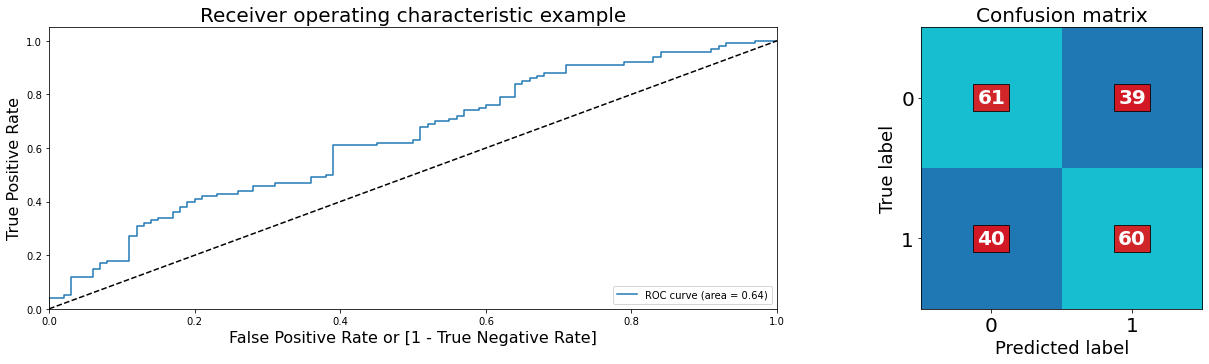

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.64  Threshold:0.52960
Accuracy 0.6 AUC: 0.64 Recall: 0.6 Precision: 0.61 F1: 0.6
fasttext_LGBM


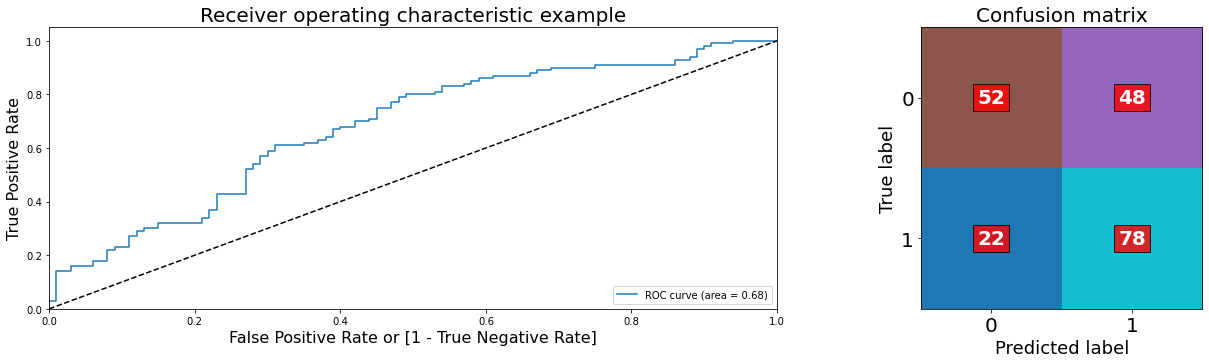

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.68  Threshold:0.48590
Accuracy 0.65 AUC: 0.68 Recall: 0.78 Precision: 0.62 F1: 0.69
fasttext_NB


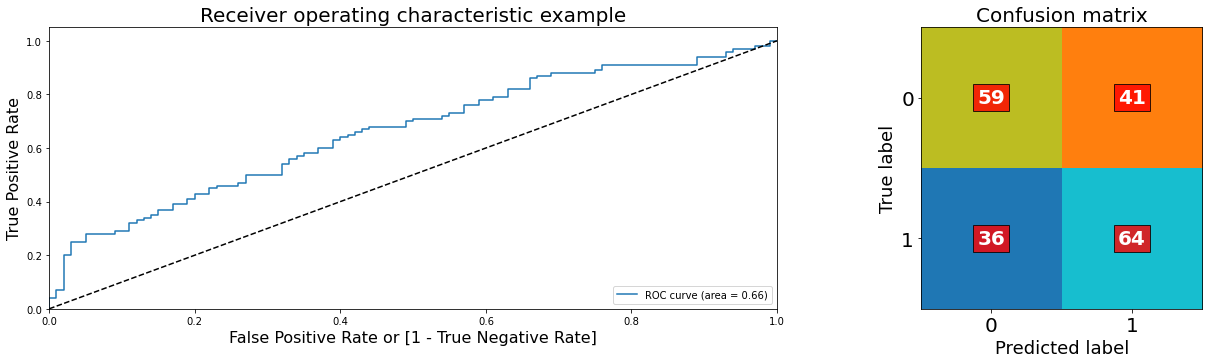

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.66  Threshold:0.88871
Accuracy 0.62 AUC: 0.66 Recall: 0.64 Precision: 0.61 F1: 0.62
fasttext_SVC


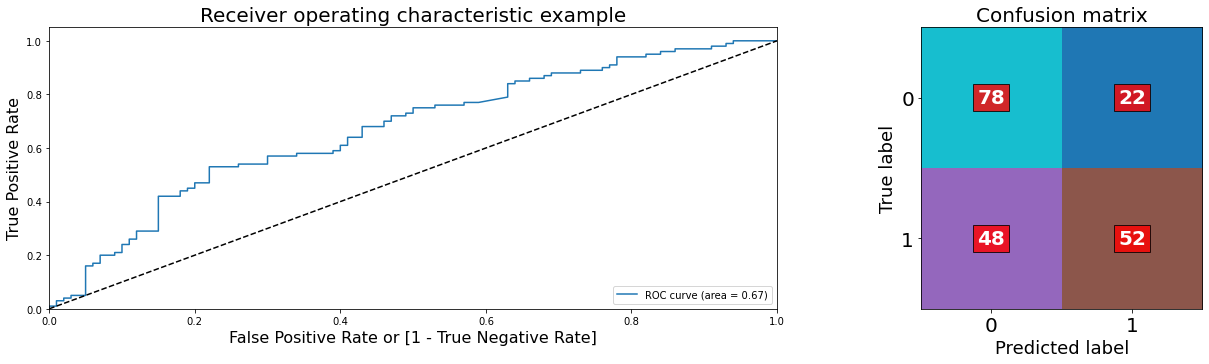

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.67  Threshold:0.61048
Accuracy 0.65 AUC: 0.67 Recall: 0.52 Precision: 0.7 F1: 0.6
fasttext_ADB


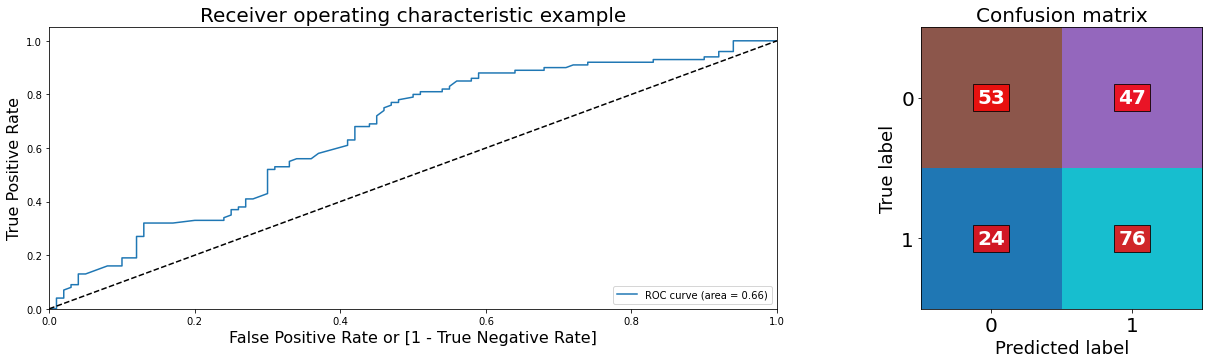

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.66  Threshold:0.49946
Accuracy 0.64 AUC: 0.66 Recall: 0.76 Precision: 0.62 F1: 0.68
fasttext_GBC


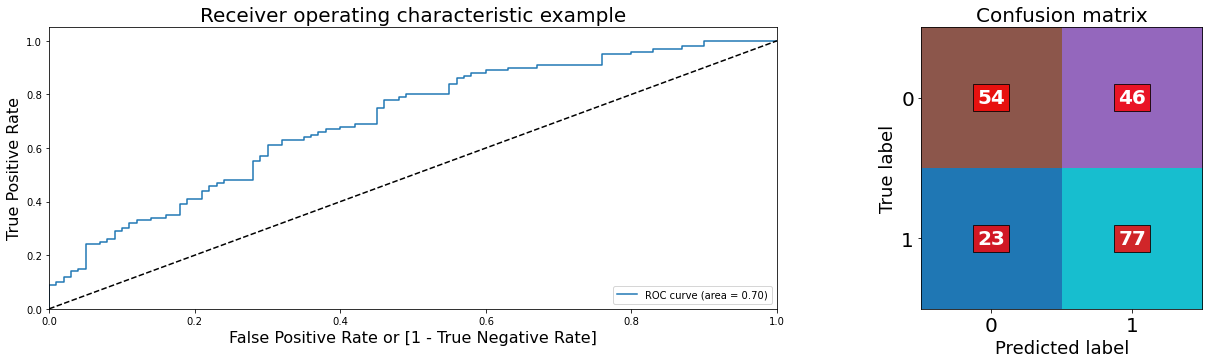

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.7  Threshold:0.49816
Accuracy 0.66 AUC: 0.7 Recall: 0.77 Precision: 0.63 F1: 0.69
fasttext_RFC


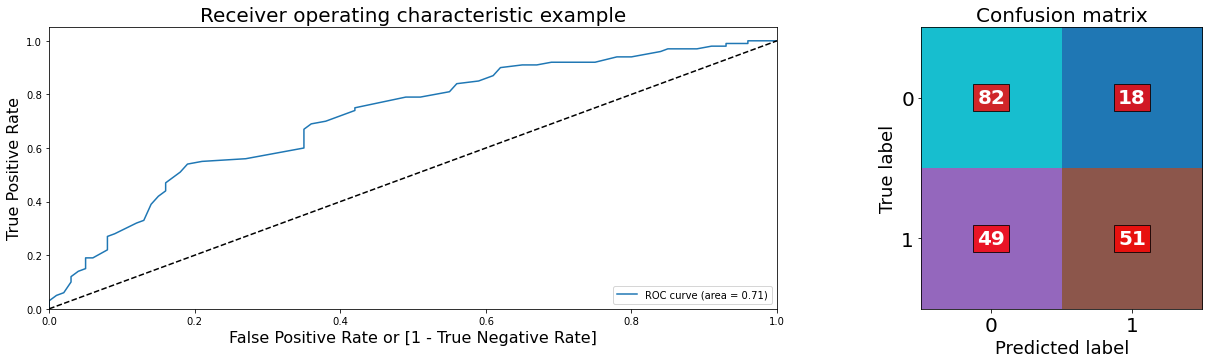

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.71  Threshold:0.63000
Accuracy 0.66 AUC: 0.71 Recall: 0.51 Precision: 0.74 F1: 0.6
fasttext_Perceptron


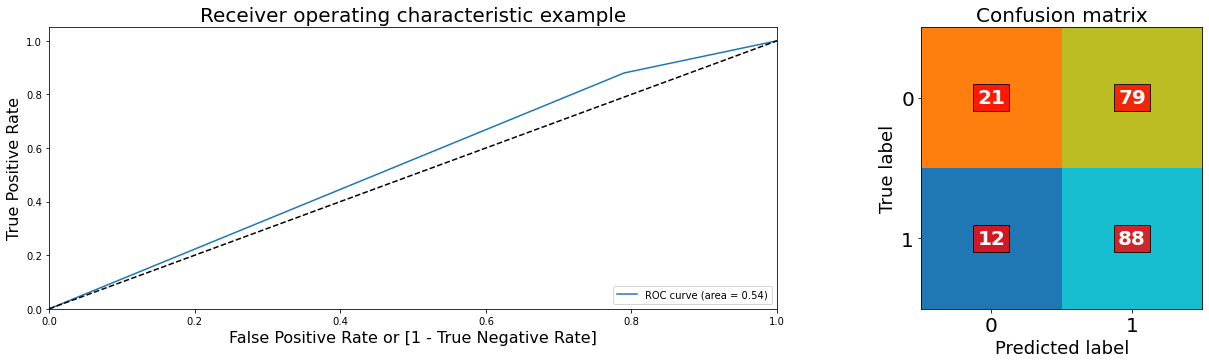

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.54  Threshold:1.00000
Accuracy 0.55 AUC: 0.54 Recall: 0.88 Precision: 0.53 F1: 0.66
fasttext_indicnlp
(1800, 300) (200, 300) (1800,) (200,)
Oversampling Technique Used:Normal
(1800, 300) (200, 300) (1800,) (200,)
(1800, 300) (1800,)
fasttext_indicnlp_LR


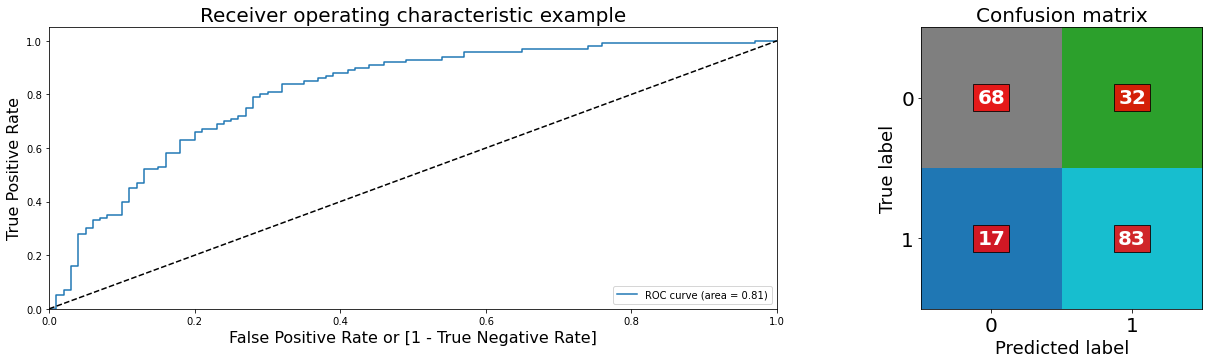

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.81  Threshold:0.48010
Accuracy 0.76 AUC: 0.81 Recall: 0.83 Precision: 0.72 F1: 0.77
fasttext_indicnlp_LGBM


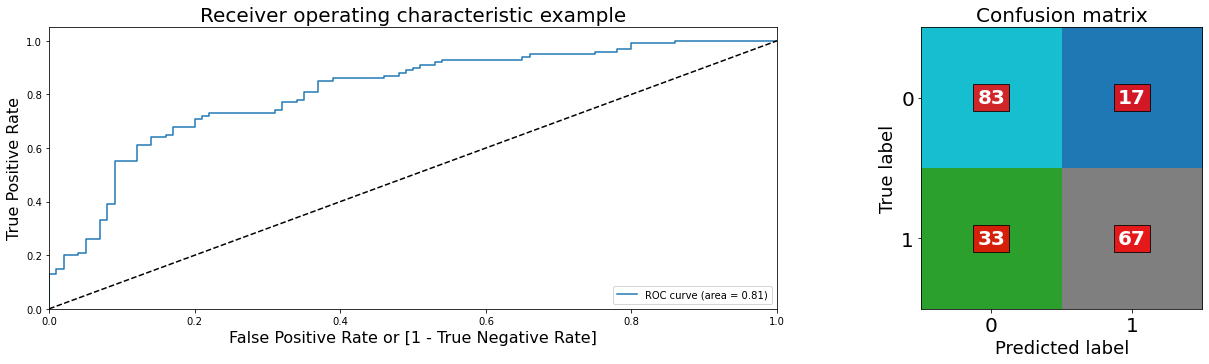

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.81  Threshold:0.47532
Accuracy 0.75 AUC: 0.81 Recall: 0.67 Precision: 0.8 F1: 0.73
fasttext_indicnlp_NB


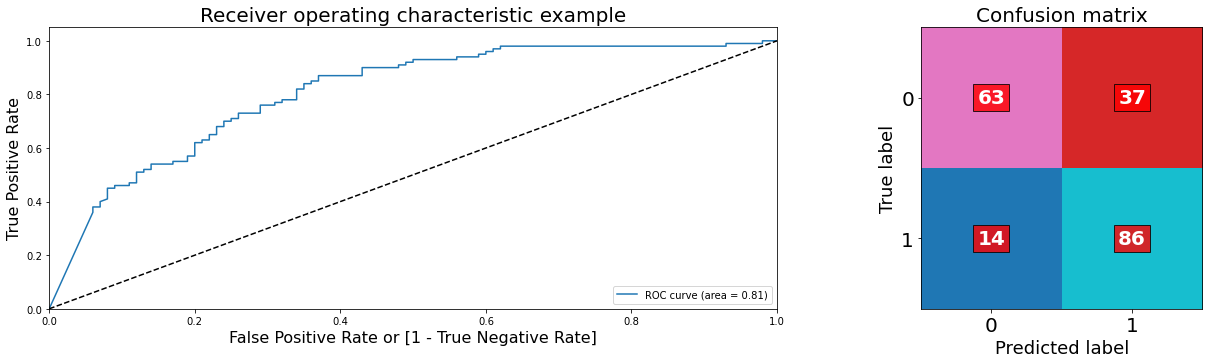

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.81  Threshold:0.00004
Accuracy 0.74 AUC: 0.81 Recall: 0.86 Precision: 0.7 F1: 0.77
fasttext_indicnlp_SVC


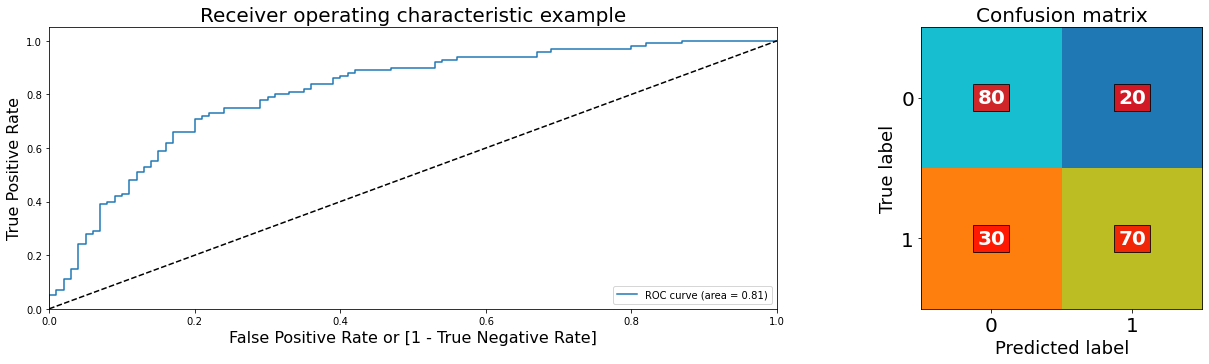

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.81  Threshold:0.45825
Accuracy 0.75 AUC: 0.81 Recall: 0.7 Precision: 0.78 F1: 0.74
fasttext_indicnlp_ADB


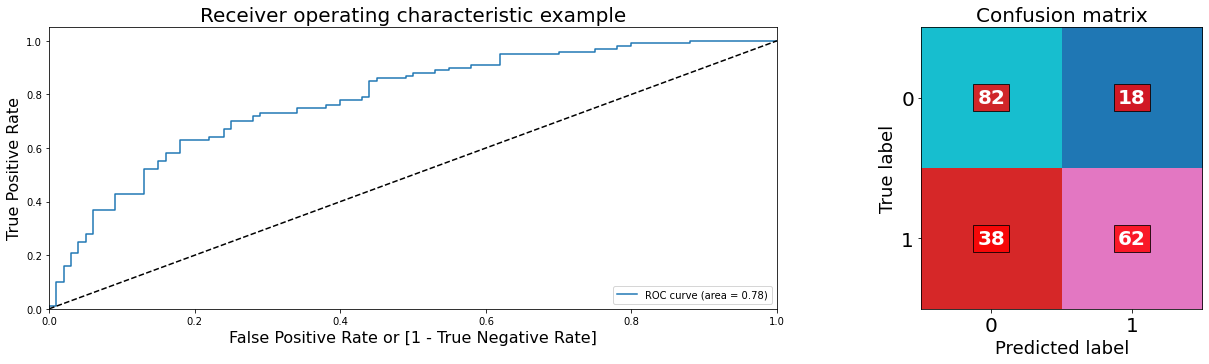

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.78  Threshold:0.50351
Accuracy 0.72 AUC: 0.78 Recall: 0.62 Precision: 0.78 F1: 0.69
fasttext_indicnlp_GBC


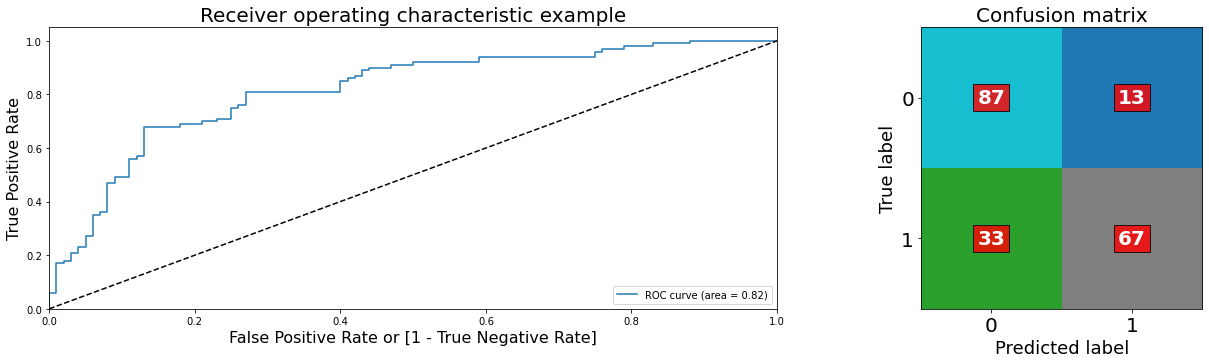

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.82  Threshold:0.57946
Accuracy 0.77 AUC: 0.82 Recall: 0.67 Precision: 0.84 F1: 0.74
fasttext_indicnlp_RFC


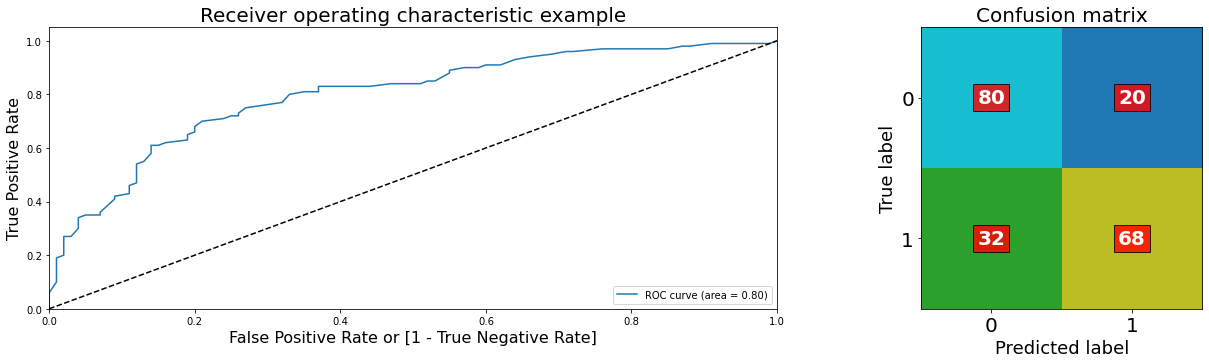

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.8  Threshold:0.45000
Accuracy 0.74 AUC: 0.8 Recall: 0.68 Precision: 0.77 F1: 0.72
fasttext_indicnlp_Perceptron


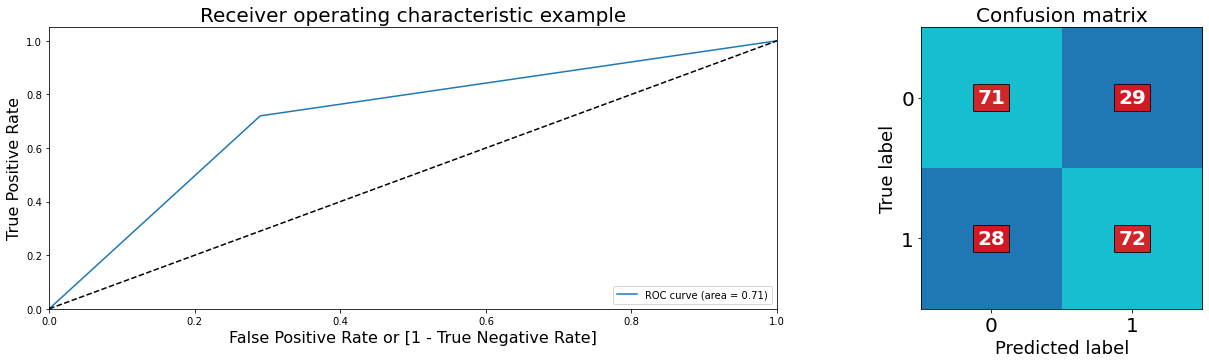

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.71  Threshold:1.00000
Accuracy 0.72 AUC: 0.71 Recall: 0.72 Precision: 0.71 F1: 0.72
fastext_wiki
(1800, 300) (200, 300) (1800,) (200,)
Oversampling Technique Used:Normal
(1800, 300) (200, 300) (1800,) (200,)
(1800, 300) (1800,)
fastext_wiki_LR


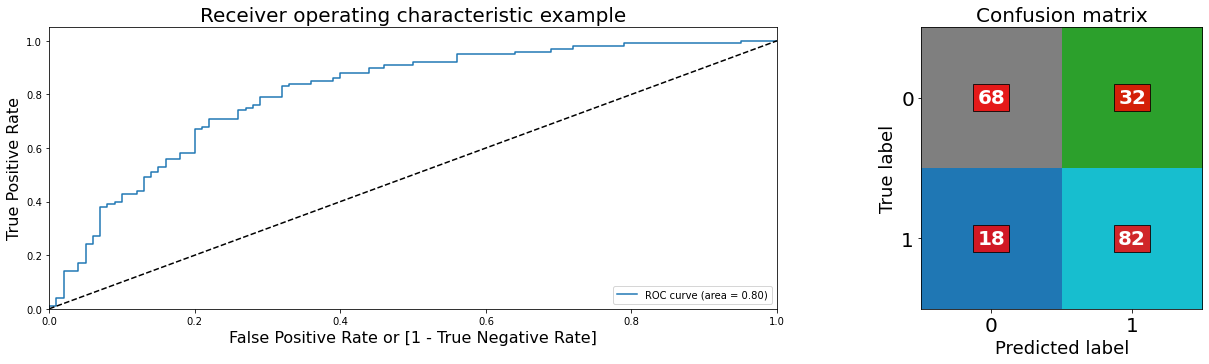

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.8  Threshold:0.47915
Accuracy 0.75 AUC: 0.8 Recall: 0.82 Precision: 0.72 F1: 0.77
fastext_wiki_LGBM


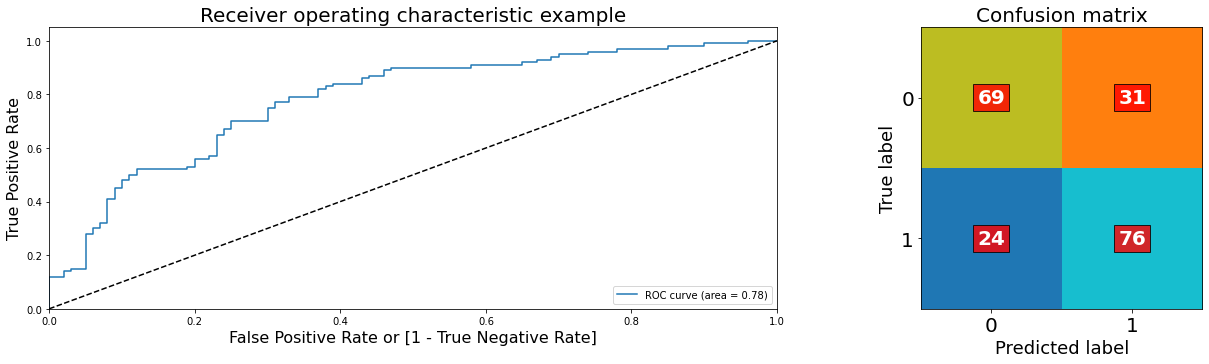

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.78  Threshold:0.21910
Accuracy 0.72 AUC: 0.78 Recall: 0.76 Precision: 0.71 F1: 0.73
fastext_wiki_NB


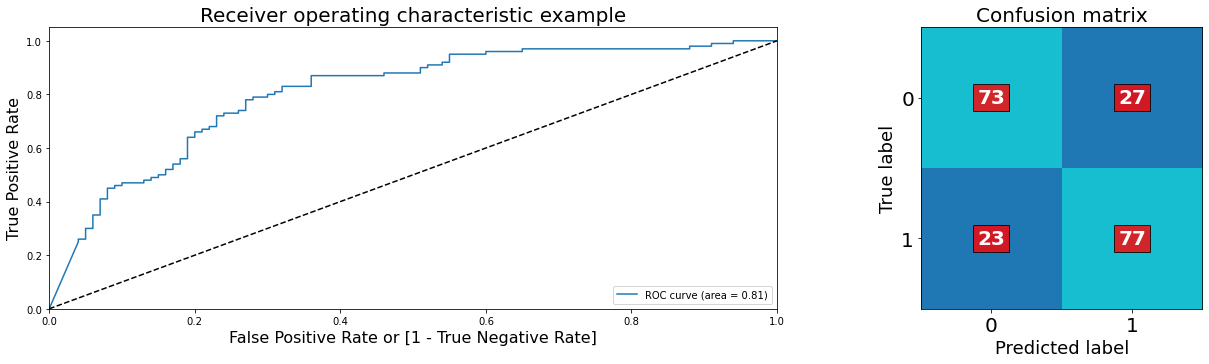

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.81  Threshold:0.30147
Accuracy 0.75 AUC: 0.81 Recall: 0.77 Precision: 0.74 F1: 0.75
fastext_wiki_SVC


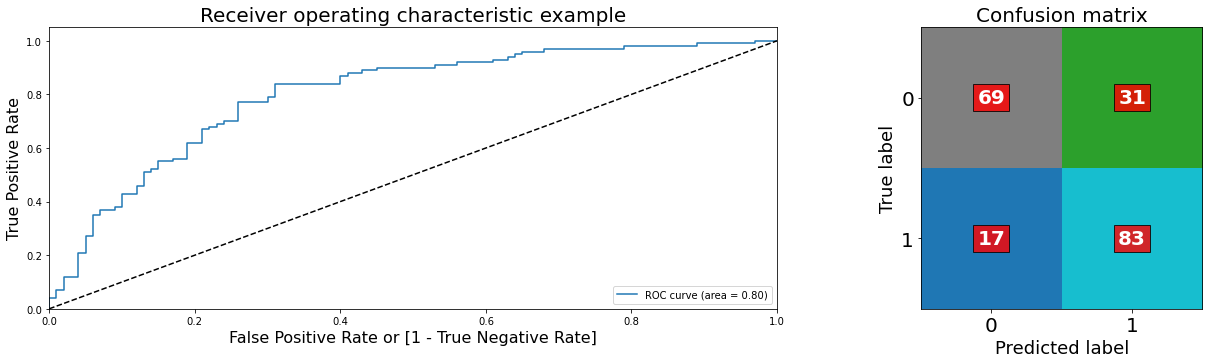

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.8  Threshold:0.13024
Accuracy 0.76 AUC: 0.8 Recall: 0.83 Precision: 0.73 F1: 0.78
fastext_wiki_ADB


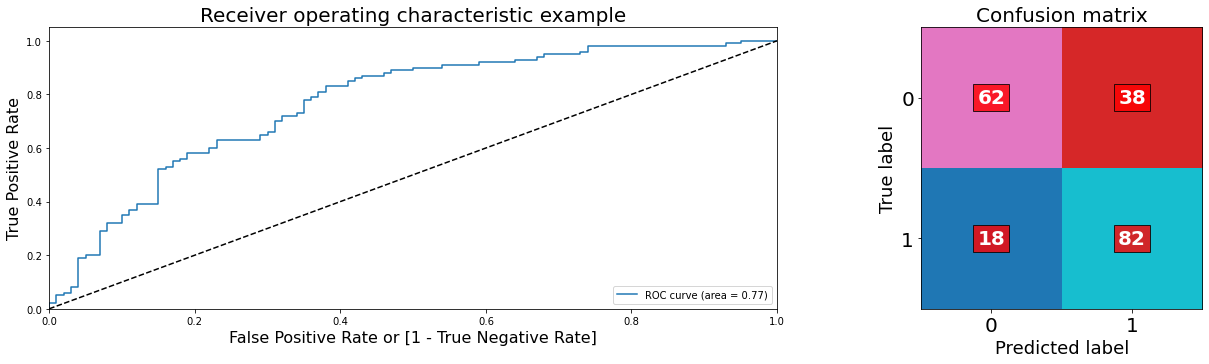

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.77  Threshold:0.47993
Accuracy 0.72 AUC: 0.77 Recall: 0.82 Precision: 0.68 F1: 0.75
fastext_wiki_GBC


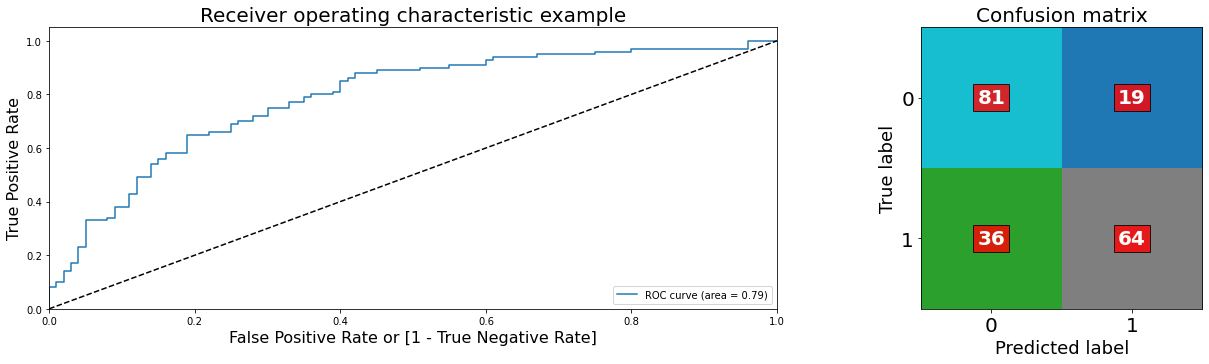

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.79  Threshold:0.50931
Accuracy 0.72 AUC: 0.79 Recall: 0.64 Precision: 0.77 F1: 0.7
fastext_wiki_RFC


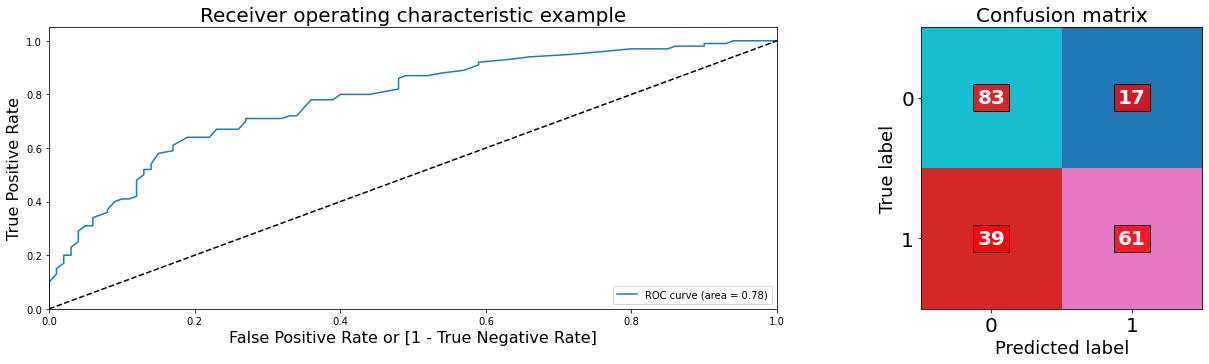

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.78  Threshold:0.52000
Accuracy 0.72 AUC: 0.78 Recall: 0.61 Precision: 0.78 F1: 0.69
fastext_wiki_Perceptron


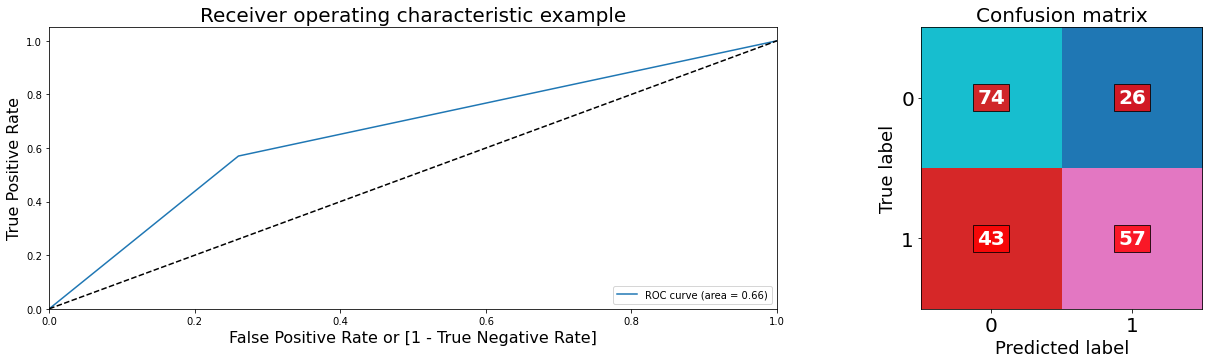

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.66  Threshold:1.00000
Accuracy 0.66 AUC: 0.66 Recall: 0.57 Precision: 0.69 F1: 0.62


KeyError: 9

In [247]:
#There are 8 embedding

embed_number=1
while embed_number<9:
    X_train,X_val, y_train, y_val = read_embedding_data(embed_number)
    process_model_LR( embed_name[embed_number]+'_LR')
    process_model_LGBM( embed_name[embed_number]+'_LGBM')
    process_model_NB( embed_name[embed_number]+'_NB')
    process_model_SVC( embed_name[embed_number]+'_SVC')
    process_model_ADB( embed_name[embed_number]+'_ADB')
    process_model_GBC( embed_name[embed_number]+'_GBC')
    process_model_RFC( embed_name[embed_number]+'_RFC')
    process_model_Perceptron(embed_name[embed_number]+'_Perceptron')
    embed_number+=1
    
#This model is no Lexical Features. LGBM Algo is used to create this model.
process_model_lbgmc_FE(embed_name[embed_number]+'_LGBM_FE')

In [1]:
embed_number

NameError: name 'embed_number' is not defined

## Save all predictions into a dataframe

In [248]:
df_prediction = pd.DataFrame(prediction)
df_prediction = df_prediction.set_index(X_val.index)

df_prediction.to_csv(datafolder_p + r'\model_predictions_'+model_with_data_list[option]+'.csv')
print ("File Name: "+ datafolder_p + r'\model_predictions_'+model_with_data_list[option]+'.csv')

#=============================================================
#Reading predictions from a afile
#df_prediction  = pd.read_csv( datafolder_p + r'\model_predictions_Normal.csv',index_col="ID" )

File Name: D:\18-DS\github\SDSHL\data\processed\model_predictions_Normal.csv


In [249]:
df_prediction.head(2)

,lgbmc_FE,tfidf_LR,tfidf_LGBM,tfidf_NB,tfidf_SVC,tfidf_ADB,tfidf_GBC,tfidf_RFC,tfidf_Perceptron,word2vec_LR,...,fasttext_indicnlp_RFC,fasttext_indicnlp_Perceptron,fastext_wiki_LR,fastext_wiki_LGBM,fastext_wiki_NB,fastext_wiki_SVC,fastext_wiki_ADB,fastext_wiki_GBC,fastext_wiki_RFC,fastext_wiki_Perceptron
ID,,,,,,,,,,,,,,,,,,,,,
5212,0.604345,0.503156,0.736336,0.573233,0.557837,0.497781,0.576849,0.55,1,0.572507,...,0.39,0,0.510229,0.699028,0.999941,0.244642,0.490337,0.442176,0.55,0
8028,0.417569,0.504351,0.731867,0.555379,0.558531,0.505281,0.527777,0.56,1,0.521972,...,0.69,1,0.521923,0.845595,1.000000,0.937660,0.521640,0.841107,0.66,1


## Merge predictions of Other Models which are not using embedding

In [250]:
#FastText Prediction using Pretrained Model with Task Finetuning
df_prediction_fasttext = pd.read_csv( datafolder_p + r'\model_predictions_fasttext.csv', index_col="ID")

#Neural Network Prediction
df_prediction_CNN      = pd.read_csv( datafolder_p + r'\model_predictions_NN.csv', index_col="ID")

#Combine All Predictions
df_prediction = pd.concat( [df_prediction,df_prediction_fasttext, df_prediction_CNN], axis=1, ignore_index=False )

#df_prediction = df_prediction.drop(columns=['label'])
#df_prediction['label'] = label

#Identify whether sentence is twitter or non-twitter. Also add label to the prediction
df_org = pd.read_csv(file_org, sep='\t', index_col='ID')
df_val = pd.read_csv(file_test, sep='\t', index_col='ID')
idx_val = df_val.index
df_prediction['label'] = df_org.loc[idx_val]['label']
df_prediction['twitter'] = df_org.loc[idx_val]['twitter']

## Calulate Metrics using Predictions done in earlier step

In [251]:
def calculate_metrics(df_prediction_, y_act_):

    tot_models=df_prediction_.shape[1]-2
    #print ('Total Modles {tot_mod}'.format(tot_mod= tot_models))
    results = np.zeros( (tot_models,5) )

    threshold= 0.5
    final_label = lambda x: 1 if x>threshold else 0

    #y_act= df_prediction1.iloc[:, tot_models]
    model_name=[]
    for i in range(tot_models):

        #print (df_prediction_.columns[i], len(y_act_), len(df_prediction_.iloc[:,i]), i )

        model_name.append( df_prediction_.columns[i])

        #print (y_act_)
        results[i][4] = np.round( metrics.roc_auc_score(y_act_,df_prediction_.iloc[:,i]), 2)

        y_pre= df_prediction_.iloc[:,i].apply(final_label)

        results[i][0] = np.round( metrics.accuracy_score(y_act_,y_pre), 2)
        results[i][1] = np.round( metrics.recall_score(y_act_,y_pre), 2)
        results[i][2] = np.round( metrics.precision_score(y_act_,y_pre), 2)
        results[i][3] = np.round( metrics.f1_score(y_act_,y_pre), 2)
        #results[i][4] = np.round( metrics.roc_auc_score(y_act,y_pre), 2)

    results1 = pd.DataFrame(results,columns=['Accuracy','Recall','Precision','F1','AUC'], index=model_name)

    return results1

In [252]:
#Split Twitter vs Non-Twitter records to to get metrics separately

df_prediction1 = df_prediction[df_prediction.twitter=='Y']
y_act1         = df_prediction[df_prediction.twitter=='Y']['label']

df_prediction2 = df_prediction[df_prediction.twitter=='N']
y_act2         = df_prediction[df_prediction.twitter=='N']['label']


#Save Metrics in a file for Reporting Purpose
fl= datafolder_p + r'\model_results_'+model_with_data_list[option]+'.csv'
print ('All Results Prediction Results in file ', fl)
results1 = calculate_metrics(df_prediction, y_act)
results1.to_csv(fl)


fl= datafolder_p + r'\model_results_'+model_with_data_list[option]+'_twitter.csv'
print ('Twitter Statement Prediction Results in file ', fl)
results1 = calculate_metrics(df_prediction1, y_act1)
results1.to_csv(fl)


fl= datafolder_p + r'\model_results_'+model_with_data_list[option]+'_wo_twitter.csv'
print ('Normal Statements Prediction Results in file ',fl)
results1 = calculate_metrics(df_prediction2, y_act2)
results1.to_csv( fl)

All Results Prediction Results in file  D:\18-DS\github\SDSHL\data\processed\model_results_Normal.csv
Twitter Statement Prediction Results in file  D:\18-DS\github\SDSHL\data\processed\model_results_Normal_twitter.csv
Normal Statements Prediction Results in file  D:\18-DS\github\SDSHL\data\processed\model_results_Normal_wo_twitter.csv


In [253]:
pd.set_option( "display.html.border" , 1 )
pd.set_option("display.max_rows",70)

In [254]:
print ("Number of Modesl {modnum}".format( modnum = len(results1)))

Number of Modesl 69


In [255]:
#Results for all Records
results1 = calculate_metrics(df_prediction, y_act)
results1.sort_values("F1",ascending=False)

,Accuracy,Recall,Precision,F1,AUC
fastext_wiki_NB,0.74,0.76,0.74,0.75,0.81
fasttext_indicnlp_GBC,0.76,0.68,0.81,0.74,0.82
fasttext_indicnlp_NB,0.73,0.75,0.72,0.74,0.81
fasttext_indicnlp_LGBM,0.75,0.67,0.80,0.73,0.81
fasttext_indicnlp_SVC,0.74,0.68,0.77,0.72,0.81
fasttext_indicnlp_Perceptron,0.72,0.72,0.71,0.72,0.71
fastext_wiki_LR,0.74,0.68,0.76,0.72,0.80
bert_multiling_LR,0.71,0.71,0.71,0.71,0.73
fasttext_indicnlp_LR,0.73,0.66,0.77,0.71,0.81
bert_multiling_Perceptron,0.58,0.97,0.54,0.70,0.58


In [256]:
#Results for Twitter Statement
results1 = calculate_metrics(df_prediction1, y_act1)
results1.sort_values("F1",ascending=False)

,Accuracy,Recall,Precision,F1,AUC
fastext_wiki_NB,0.73,0.76,0.70,0.73,0.78
fasttext_indicnlp_GBC,0.75,0.68,0.77,0.72,0.80
fasttext_RFC,0.69,0.81,0.63,0.71,0.72
fasttext_LGBM,0.68,0.84,0.62,0.71,0.70
fasttext_indicnlp_LGBM,0.74,0.68,0.75,0.71,0.80
bert_multiling_LR,0.71,0.76,0.67,0.71,0.71
fasttext_indicnlp_SVC,0.72,0.68,0.72,0.70,0.78
fasttext_indicnlp_LR,0.72,0.65,0.72,0.69,0.79
fasttext_indicnlp_NB,0.69,0.73,0.65,0.69,0.77
fastext_wiki_LR,0.72,0.67,0.71,0.69,0.78


In [257]:
#Results for Non-Twitter Statement
results1 = calculate_metrics(df_prediction2, y_act2)
results1.sort_values("F1",ascending=False)

,Accuracy,Recall,Precision,F1,AUC
fasttext_indicnlp_NB,0.88,0.80,1.00,0.89,0.98
lgbmc_FE,0.80,0.84,0.84,0.84,0.82
fastext_wiki_GBC,0.83,0.72,1.00,0.84,0.92
bert_indicnlp_RFC,0.80,0.76,0.90,0.83,0.84
fasttext_wiki_pretrained,0.80,0.76,0.90,0.83,0.88
fastext_wiki_NB,0.80,0.76,0.90,0.83,0.94
fastext_wiki_LR,0.80,0.72,0.95,0.82,0.89
bert_multiling_Perceptron,0.73,1.00,0.69,0.82,0.66
fasttext_indicnlp_SVC,0.80,0.68,1.00,0.81,0.93
fasttext_indicnlp_Perceptron,0.78,0.72,0.90,0.80,0.80


In [238]:
df = pd.read_csv(datafolder_p + r'\4-Hinglish_Sarcasm_Clean_FE.csv', sep='\t', index_col="ID")
df_train = pd.read_csv( file_train, sep='\t', index_col="ID")
idx_train= df_train.index
df_val   = pd.read_csv( file_test, sep='\t', index_col="ID")
idx_val  = df_val.index

df_train = df.loc[idx_train]
df_val   = df.loc[idx_val]

X_train = df_train.drop("label", axis=1)
y_train = df_train['label']

X_val = df_val.drop("label", axis=1)
y_val = df_val['label']

In [ ]:
lgbmc_FE()

In [244]:
prediction

{'lgbmc_FE': 0      0.604345
 1      0.417569
 2      0.061017
 3      0.458863
 4      0.814246
          ...   
 195    0.069578
 196    0.613977
 197    0.076542
 198    0.566119
 199    0.798854
 Name: Class_Prob, Length: 200, dtype: float64}